# Semantic change in LatinISE


Barbara McGillivray

This notebook contains the code for detecting semantic change in the Latin corpus LatinISe using word embeddings.

## Initialisation

I install version 4.0 of gensim, which is needed to train the word2vec models.

In [1]:
!pip install gensim==4.0
!pip install plotly


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


Import libraries

In [2]:
import os 
#from bs4 import BeautifulSoup
import csv
import numpy as np
import pandas as pd
#from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
#from nltk.corpus import stopwords
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from gensim.models import FastText
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import spacy
import plotly.express as px
import re
from statistics import mean
#from langdetect import detect
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Parameters

I set the parameters of the analysis.

In [3]:
lemmas_or_tokens = "lemmas" # this can be "lemmas" or "tokens"

## Reading the files

I define the name of the folders:

In [4]:
dir_in = os.path.join("/Users", "barbaramcgillivray", "OneDrive - King's College London", "Research", "2022", "Nexus Linguarum WG4 UC4.2",  "LatinISE")
dir_out = os.path.join(dir_in, "semantic_change_output")

I define the list of all files:

In [5]:
files = os.listdir(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens))

How many files are in the folder?


In [6]:
len(files)

1268

We only want IntraText files:

In [7]:
files = [f for f in files[:] if "IT" in f]
len(files)

670

I read the metadata file:

In [8]:
metadata_df = pd.read_csv(os.path.join(dir_in, 'latinise_metadata.csv'), sep = ",")
metadata_df = metadata_df[metadata_df['id'].str.startswith("IT")]
metadata_df

id                          title  \
18      IT-LAT0001                        Vulgata   
19      IT-LAT0537                   Ars amatoria   
20      IT-LAT0011            S. Benedicti Regula   
21      IT-LAT0012   In psalmis Davidis expositio   
22      IT-LAT0014                Adoro te devote   
...            ...                            ...   
683   IT-LAT0534_1  De origine et situ Germanorum   
684   IT-LAT0534_2        De vita Iulii Agricolae   
685   IT-LAT0534_3         Dialogus de oratoribus   
686   IT-LAT0534_4                      Historiae   
1265    IT-LAT0202                  Institutiones   

                                                creator    date    type  \
18                                           Hieronymus   382.0  poetry   
19                                Ovidius Naso, Publius    -9.0  poetry   
20                                 Benedictus Nursianus   524.0   prose   
21                              Thomas Aquinas: Sanctus  1254.0   prose   
22                              Thomas Aquinas: Sanctus  1254.0  poetry   
...                                                 ...     ...     ...   
683                  Tacitus, Publius (Gaius) Cornelius   116.0   prose   
684                  Tacitus, Publius (Gaius) Cornelius   116.0   prose   
685                  Tacitus, Publius (Gaius) Cornelius   116.0   prose   
686                  Tacitus, Publius (Gaius) Cornelius   116.0   prose   
1265  Iustinianus, Caesar Flavius (Imperator Iustini...   533.0   prose   

                           file  
18      lat_0382_IT-LAT0001.txt  
19      lat_-009_IT-LAT0537.txt  
20      lat_0524_IT-LAT0011.txt  
21      lat_1254_IT-LAT0012.txt  
22      lat_1254_IT-LAT0014.txt  
...                         ...  
683   lat_0116_IT-LAT0534_1.txt  
684   lat_0116_IT-LAT0534_2.txt  
685   lat_0116_IT-LAT0534_3.txt  
686   lat_0116_IT-LAT0534_4.txt  
1265    lat_0533_IT-LAT0202.txt  

[670 rows x 6 columns]

In [9]:
metadata_df.shape

(670, 6)

In [10]:
metadata_df.columns

Index(['id', 'title', 'creator', 'date', 'type', 'file'], dtype='object')

In [11]:
metadata_df['date'].describe

<bound method NDFrame.describe of 18       382.0
19        -9.0
20       524.0
21      1254.0
22      1254.0
         ...  
683      116.0
684      116.0
685      116.0
686      116.0
1265     533.0
Name: date, Length: 670, dtype: float64>

In [12]:
metadata_df.dtypes

id          object
title       object
creator     object
date       float64
type        object
file        object
dtype: object

Convert date to integer

In [13]:
metadata_df['date'] = metadata_df['date'].astype(int)
metadata_df.dtypes

id         object
title      object
creator    object
date        int64
type       object
file       object
dtype: object

In [14]:
metadata_df.head

<bound method NDFrame.head of                 id                          title  \
18      IT-LAT0001                        Vulgata   
19      IT-LAT0537                   Ars amatoria   
20      IT-LAT0011            S. Benedicti Regula   
21      IT-LAT0012   In psalmis Davidis expositio   
22      IT-LAT0014                Adoro te devote   
...            ...                            ...   
683   IT-LAT0534_1  De origine et situ Germanorum   
684   IT-LAT0534_2        De vita Iulii Agricolae   
685   IT-LAT0534_3         Dialogus de oratoribus   
686   IT-LAT0534_4                      Historiae   
1265    IT-LAT0202                  Institutiones   

                                                creator  date    type  \
18                                           Hieronymus   382  poetry   
19                                Ovidius Naso, Publius    -9  poetry   
20                                 Benedictus Nursianus   524   prose   
21                              Thomas Aq

Number of works per year:

In [15]:
metadata_df0 = metadata_df.groupby(['date']).count()
metadata_df0 = metadata_df0['id']
metadata_df0

date
-450     1
-229     1
-199     3
-185     1
-149     2
        ..
 2001    4
 2002    2
 2003    1
 2004    1
 2005    1
Name: id, Length: 263, dtype: int64

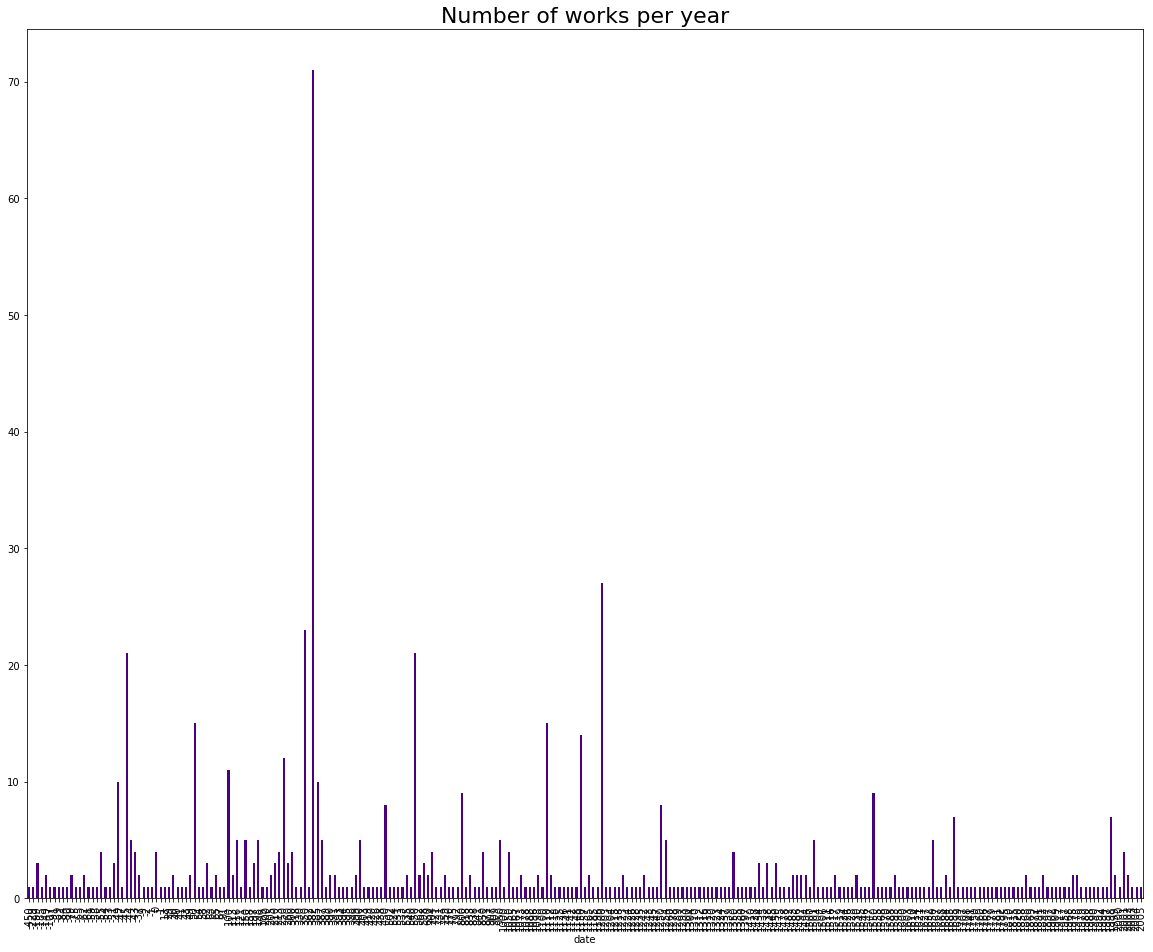

In [16]:
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per year", fontsize=22)
plt.show()

## Split the corpus into subcorpora

Find the first and last year in the dataset:

In [17]:
first_date = min(metadata_df.date)
last_date = max(metadata_df.date)
print(first_date)
print(last_date)

-450
2005


We stop at 900 CE.

In [18]:
last_date = 900

Define size of the time intervals:

In [19]:
size_interval = 450

So there are

In [20]:
n_intervals = round((last_date-first_date)/size_interval)
n_intervals

3

time intervals.

Define the time periods and split the corpus:

In [21]:
intervals = [None]*(n_intervals+1)
for t in range(n_intervals+1):
    #print(t)
    if t == 0:
        intervals[t] = int(first_date)
    else:
        intervals[t] = int(intervals[t-1]+size_interval)
    #print(intervals[t])
    
print(intervals)

[-450, 0, 450, 900]


Add a column to the metadata_df for the time interval:

In [22]:
metadata_df['time_interval'] = ""
for t in range(len(intervals)-1):
    print(t)
    print(range(intervals[t],intervals[t+1]))
    metadata_df_t = metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1]))]
    print(metadata_df_t.date)
    metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1])),'time_interval'] = intervals[t]
metadata_df

0
range(-450, 0)
19      -9
34     -49
39     -45
42     -49
57     -80
      ... 
635   -149
638   -107
642    -37
643    -37
649   -229
Name: date, Length: 77, dtype: int64
1
range(0, 450)
18     382
23     399
24     391
37     158
38      49
      ... 
682    382
683    116
684    116
685    116
686    116
Name: date, Length: 235, dtype: int64
2
range(450, 900)
20      524
102     800
104     800
105     800
106     800
       ... 
609     598
634     550
636     550
645     450
1265    533
Name: date, Length: 73, dtype: int64


id                          title  \
18      IT-LAT0001                        Vulgata   
19      IT-LAT0537                   Ars amatoria   
20      IT-LAT0011            S. Benedicti Regula   
21      IT-LAT0012   In psalmis Davidis expositio   
22      IT-LAT0014                Adoro te devote   
...            ...                            ...   
683   IT-LAT0534_1  De origine et situ Germanorum   
684   IT-LAT0534_2        De vita Iulii Agricolae   
685   IT-LAT0534_3         Dialogus de oratoribus   
686   IT-LAT0534_4                      Historiae   
1265    IT-LAT0202                  Institutiones   

                                                creator  date    type  \
18                                           Hieronymus   382  poetry   
19                                Ovidius Naso, Publius    -9  poetry   
20                                 Benedictus Nursianus   524   prose   
21                              Thomas Aquinas: Sanctus  1254   prose   
22                              Thomas Aquinas: Sanctus  1254  poetry   
...                                                 ...   ...     ...   
683                  Tacitus, Publius (Gaius) Cornelius   116   prose   
684                  Tacitus, Publius (Gaius) Cornelius   116   prose   
685                  Tacitus, Publius (Gaius) Cornelius   116   prose   
686                  Tacitus, Publius (Gaius) Cornelius   116   prose   
1265  Iustinianus, Caesar Flavius (Imperator Iustini...   533   prose   

                           file time_interval  
18      lat_0382_IT-LAT0001.txt             0  
19      lat_-009_IT-LAT0537.txt          -450  
20      lat_0524_IT-LAT0011.txt           450  
21      lat_1254_IT-LAT0012.txt                
22      lat_1254_IT-LAT0014.txt                
...                         ...           ...  
683   lat_0116_IT-LAT0534_1.txt             0  
684   lat_0116_IT-LAT0534_2.txt             0  
685   lat_0116_IT-LAT0534_3.txt             0  
686   lat_0116_IT-LAT0534_4.txt             0  
1265    lat_0533_IT-LAT0202.txt           450  

[670 rows x 7 columns]

Visualise distribution of time intervals:

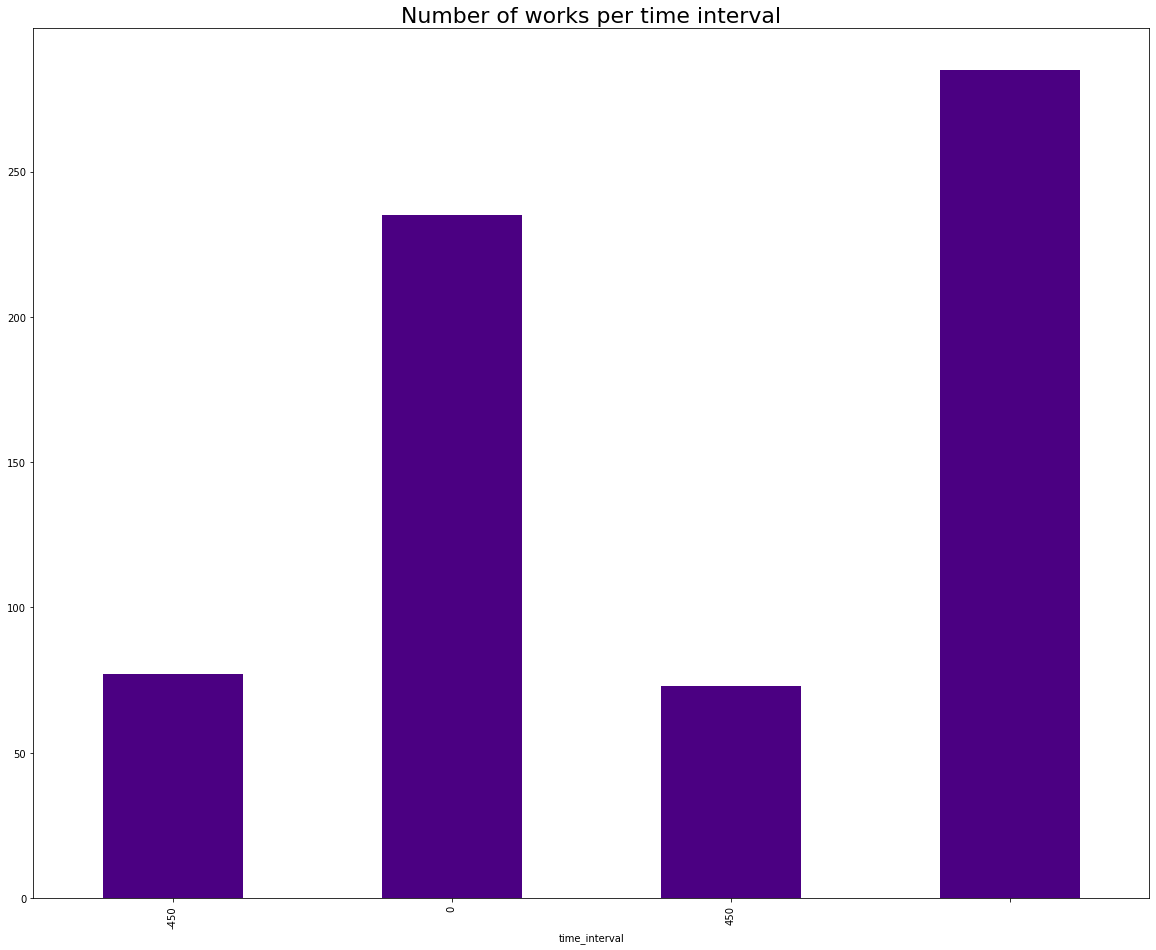

In [23]:
metadata_df0 = metadata_df.groupby(['time_interval']).count()
metadata_df0 = metadata_df0['id']
metadata_df0
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per time interval", fontsize=22)
plt.show()

We may want to do something about this inbalance. See further down for the "Historical subcorpus".

## Training embeddings for the whole corpus

Function for printing the vocabulary of a model

In [24]:
def print_vocab(model, top_n = None):
  if model == '':
    print("Empty model!")
  else:
    count = 0
    if top_n is not None:
      for index, word in enumerate(model.wv.index_to_key):
        count+= 1
        if count < top_n:
          print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
    else:
      for index, word in enumerate(model.wv.index_to_key):
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

Function that converts dates into the standard format:

In [25]:
def convert_dates(sign, date0):

    if sign == "0":
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = "+" + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = "+" + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = "+" + str(date0)
            #print("3-final_date", final_date)
    else:
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = str(sign) + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = str(sign) + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = str(sign) + str(date0)
            #print("3-final_date", final_date)

    if final_date.startswith("+"):
        final_date = final_date.replace("+", "")
    return final_date

#### Stopwords exclusion and further filtering


I exclude punctuation marks:

In [26]:
punctuation = ['.', ',', '...', ';', ':', '?']

I create a list of lists, containing the tokens of each sentence in the whole corpus:

In [27]:
corpus = list()
files_corpus = metadata_df
for index, df_line in files_corpus.iterrows():
    #print("line:",df_line['id'], df_line['time_interval'])
    sign = "+"
    #print(df_line['date'])
    if df_line['date'] < 0:
        sign = "-"
    #print("date:", convert_dates(sign, abs(df_line['date'])))
    file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
    print("3:",file_name)
    file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
    sentences_this_file = list()
    while True:
        line = file.readline().strip()
        if line != "":
            #sentences_this_file.append(line.split(" "))
            #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
            corpus.append([token for token in line.split(" ") if token not in punctuation])
        # if line is empty end of file is reached
        if not line:
            break
    file.close()
corpus.append(sentences_this_file)

3: lat_0382_IT-LAT0001.txt
3: lat_-009_IT-LAT0537.txt
3: lat_0524_IT-LAT0011.txt
3: lat_1254_IT-LAT0012.txt
3: lat_1254_IT-LAT0014.txt
3: lat_0399_IT-LAT0015.txt
3: lat_0391_IT-LAT0016.txt
3: lat_1224_IT-LAT0017.txt
3: lat_1150_IT-LAT0018.txt
3: lat_2000_IT-LAT0021.txt
3: lat_1517_IT-LAT0022.txt
3: lat_1547_IT-LAT0023.txt
3: lat_1530_IT-LAT0024.txt
3: lat_1260_IT-LAT0025.txt
3: lat_1250_IT-LAT0026.txt
3: lat_1998_IT-LAT0027.txt
3: lat_-0049_IT-LAT0029.txt
3: lat_2001_IT-LAT0030.txt
3: lat_1992_IT-LAT0031.txt
3: lat_0158_IT-LAT0043.txt
3: lat_0049_IT-LAT0045.txt
3: lat_-0045_IT-LAT0047.txt
3: lat_0050_IT-LAT0051.txt
3: lat_0121_IT-LAT0054.txt
3: lat_-0049_IT-LAT0056.txt
3: lat_0199_IT-LAT0058.txt
3: lat_0387_IT-LAT0061.txt
3: lat_0197_IT-LAT0062.txt
3: lat_0050_IT-LAT0563.txt
3: lat_0062_IT-LAT0071.txt
3: lat_0049_IT-LAT0072.txt
3: lat_0063_IT-LAT0073.txt
3: lat_0000_IT-LAT0075.txt
3: lat_0062_IT-LAT0078.txt
3: lat_0058_IT-LAT0079.txt
3: lat_0385_IT-LAT0574.txt
3: lat_0040_IT-LAT0083.tx

3: lat_0382_IT-LAT0001_8.txt
3: lat_0382_IT-LAT0001_9.txt
3: lat_0382_IT-LAT0001_10.txt
3: lat_0382_IT-LAT0001_11.txt
3: lat_0382_IT-LAT0001_12.txt
3: lat_1546_IT-LAT0558.txt
3: lat_1519_IT-LAT0559.txt
3: lat_1516_IT-LAT0560.txt
3: lat_1506_IT-LAT0561.txt
3: lat_0050_IT-LAT0563_1.txt
3: lat_0382_IT-LAT0001_13.txt
3: lat_0382_IT-LAT0001_14.txt
3: lat_0382_IT-LAT0001_15.txt
3: lat_1820_IT-LAT0567.txt
3: lat_1360_IT-LAT0568.txt
3: lat_1530_IT-LAT0569.txt
3: lat_1517_IT-LAT0570.txt
3: lat_1998_IT-LAT0571.txt
3: lat_1998_IT-LAT0572.txt
3: lat_1815_IT-LAT0573.txt
3: lat_1478_IT-LAT0575.txt
3: lat_1486_IT-LAT0576.txt
3: lat_1445_IT-LAT0577.txt
3: lat_1750_IT-LAT0579.txt
3: lat_1050_IT-LAT0580.txt
3: lat_1868_IT-LAT0581.txt
3: lat_1868_IT-LAT0582.txt
3: lat_1869_IT-LAT0583.txt
3: lat_1065_IT-LAT0584.txt
3: lat_0382_IT-LAT0001_16.txt
3: lat_1494_IT-LAT0586.txt
3: lat_1550_IT-LAT0587.txt
3: lat_0050_IT-LAT0588_2.txt
3: lat_1632_IT-LAT0590.txt
3: lat_1668_IT-LAT0591.txt
3: lat_0382_IT-LAT0001_17.

3: lat_1550_IT-LAT0991.txt
3: lat_-0107_IT-LAT0992.txt
3: lat_1621_IT-LAT0993.txt
3: lat_1614_IT-LAT0994.txt
3: lat_1685_IT-LAT0995.txt
3: lat_-0037_IT-LAT0996.txt
3: lat_-0037_IT-LAT0997.txt
3: lat_1501_IT-LAT1000.txt
3: lat_0450_IT-LAT1001.txt
3: lat_1483_IT-LAT1002.txt
3: lat_1550_IT-LAT1003.txt
3: lat_0395_IT-LAT1004.txt
3: lat_-0229_IT-LAT1006.txt
3: lat_1555_IT-LAT1007.txt
3: lat_1684_IT-LAT1008.txt
3: lat_1684_IT-LAT1009.txt
3: lat_0382_IT-LAT0001_41.txt
3: lat_0382_IT-LAT0001_42.txt
3: lat_0382_IT-LAT0001_43.txt
3: lat_0382_IT-LAT0001_44.txt
3: lat_0382_IT-LAT0001_45.txt
3: lat_0382_IT-LAT0001_46.txt
3: lat_0382_IT-LAT0001_47.txt
3: lat_0382_IT-LAT0001_48.txt
3: lat_0382_IT-LAT0001_49.txt
3: lat_0382_IT-LAT0001_50.txt
3: lat_0382_IT-LAT0001_51.txt
3: lat_0382_IT-LAT0001_52.txt
3: lat_0382_IT-LAT0001_53.txt
3: lat_0382_IT-LAT0001_54.txt
3: lat_0382_IT-LAT0001_55.txt
3: lat_0382_IT-LAT0001_56.txt
3: lat_0382_IT-LAT0001_57.txt
3: lat_0382_IT-LAT0001_58.txt
3: lat_0382_IT-LAT0001_5

In [28]:
metadata_df

id                          title  \
18      IT-LAT0001                        Vulgata   
19      IT-LAT0537                   Ars amatoria   
20      IT-LAT0011            S. Benedicti Regula   
21      IT-LAT0012   In psalmis Davidis expositio   
22      IT-LAT0014                Adoro te devote   
...            ...                            ...   
683   IT-LAT0534_1  De origine et situ Germanorum   
684   IT-LAT0534_2        De vita Iulii Agricolae   
685   IT-LAT0534_3         Dialogus de oratoribus   
686   IT-LAT0534_4                      Historiae   
1265    IT-LAT0202                  Institutiones   

                                                creator  date    type  \
18                                           Hieronymus   382  poetry   
19                                Ovidius Naso, Publius    -9  poetry   
20                                 Benedictus Nursianus   524   prose   
21                              Thomas Aquinas: Sanctus  1254   prose   
22                              Thomas Aquinas: Sanctus  1254  poetry   
...                                                 ...   ...     ...   
683                  Tacitus, Publius (Gaius) Cornelius   116   prose   
684                  Tacitus, Publius (Gaius) Cornelius   116   prose   
685                  Tacitus, Publius (Gaius) Cornelius   116   prose   
686                  Tacitus, Publius (Gaius) Cornelius   116   prose   
1265  Iustinianus, Caesar Flavius (Imperator Iustini...   533   prose   

                           file time_interval  
18      lat_0382_IT-LAT0001.txt             0  
19      lat_-009_IT-LAT0537.txt          -450  
20      lat_0524_IT-LAT0011.txt           450  
21      lat_1254_IT-LAT0012.txt                
22      lat_1254_IT-LAT0014.txt                
...                         ...           ...  
683   lat_0116_IT-LAT0534_1.txt             0  
684   lat_0116_IT-LAT0534_2.txt             0  
685   lat_0116_IT-LAT0534_3.txt             0  
686   lat_0116_IT-LAT0534_4.txt             0  
1265    lat_0533_IT-LAT0202.txt           450  

[670 rows x 7 columns]

In [29]:
corpus

[['in', 'principium', 'creo', 'deus', 'caelum', 'et', 'terra'],
 ['terra',
  'autem',
  'sum',
  'inanis',
  'et',
  'vacuus',
  'et',
  'tenebrae',
  'super',
  'facies',
  'abyssus',
  'et',
  'spiritus',
  'deus',
  'fero',
  'super',
  'aqua'],
 ['dico', 'deus', 'fio', 'lux', 'et', 'facio', 'sum', 'lux'],
 ['et',
  'video',
  'deus',
  'lux',
  'quod',
  'sum',
  'bonus',
  'et',
  'divisor',
  'lux',
  'atque',
  'tenebrae'],
 ['appello',
  'lux',
  'dies',
  'et',
  'tenebrae',
  'nox',
  'factumque',
  'sum',
  'vesper',
  'et',
  'mane',
  'dies',
  'unus'],
 ['dico#2',
  'quoque',
  'deus',
  'fio',
  'firmamentum',
  'in',
  'medius',
  'aqua',
  'et',
  'divido',
  'aqua',
  'ab',
  'aqua'],
 ['et',
  'facio',
  'deus',
  'firmamentum',
  'divisitque',
  'aqua',
  'quis#2',
  'sum',
  'sub',
  'firmamentum',
  'ab',
  'hic',
  'quis#2',
  'sum',
  'super',
  'firmamentum',
  'et',
  'facio',
  'sum',
  'ita'],
 ['voco',
  'deus',
  'firmamentum',
  'caelum',
  'et',
  'facio

In [30]:
len(corpus)

512576

Function for training FastText models (from Krzysztof Nowak):

In [31]:
def fasttext(self, opts=dict()):
        """
        Reads sentences from the corpus. Implements:
            https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText
        Returns
        -------
        FastText model
        """
        default_opts = dict(vector_size=100, alpha=0.025,
                            window=5, min_count=5, epochs=5)
        opts_new = default_opts
        for opt in opts.keys():
            opts_new[opt] = opts[opt]
        model = FastText(
            vector_size=opts_new["vector_size"],
            alpha=opts_new["alpha"],
            window=opts_new["window"],
            min_count=opts_new["min_count"])
        model.build_vocab(corpus_iterable=[sentence for sentence in
                                           self.corpus.get_sents()])
        total_examples = model.corpus_count
        model.train(corpus_iterable=[sentence for sentence
                                     in self.corpus.get_sents()],
                    total_examples=total_examples,
                    epochs=opts_new["epochs"])
        return model

Parameters: 

`min_count`: the minimum frequency threshold allowed for a word to be included; set to 3 following Ribary & McGillivray (2020) or 5 following Sprugnoli et al. (2019).

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000. Set to 100 following Ribary & McGillivray (2020).

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10. Set to 10 following Sprugnoli et al. (2020).

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW. Set to 10 following Ribary & McGillivray (2020).


Train FastText embeddings and, for full reproducibility, limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling:

In [141]:
model = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

(33210810, 44714280)

Let's see what words are similar to "dies":

In [142]:
model.wv.similar_by_word('dies', 10)

[('hora', 0.7181485891342163),
 ('annus', 0.6502978801727295),
 ('mensis', 0.6495981216430664),
 ('meridies', 0.63538658618927),
 ('mensium', 0.6009042263031006),
 ('anchora', 0.5829669237136841),
 ('nox', 0.5721181631088257),
 ('ann', 0.5675910711288452),
 ('triduum', 0.5575207471847534),
 ('amphora', 0.5548365116119385)]

Let's try with different parameters:

In [143]:
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

It has taken 2110 seconds


[('diesim', 0.9271528720855713),
 ('indies', 0.8521908521652222),
 ('diescit', 0.7708606719970703),
 ('meridies', 0.7479645609855652),
 ('diesque', 0.7317455410957336),
 ('hora', 0.7265593409538269),
 ('octies', 0.7099093198776245),
 ('novies', 0.698206901550293),
 ('mensis', 0.6978472471237183),
 ('sexies', 0.6701620817184448)]

In [144]:
start = time.time()
model = FastText(vector_size=100, window=10, min_count=5, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

It has taken 4127 seconds


[('diesim', 0.9374911189079285),
 ('indies', 0.8496040105819702),
 ('diescit', 0.7861834168434143),
 ('diesque', 0.7594969272613525),
 ('hora', 0.7350354790687561),
 ('meridies', 0.73321533203125),
 ('novies', 0.7067390084266663),
 ('octies', 0.6998693346977234),
 ('mensis', 0.6822937726974487),
 ('diecula', 0.644839346408844)]

I experiment with two equivalent ways to train a Fast Text model:

In [145]:
model = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.corpus_count
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

(33210810, 44714280)

In [146]:
model2 = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash, 
                  sentences=corpus)
model2.corpus_count

512576

In [147]:
np.allclose(model.wv['dies'], model2.wv['dies'])

True

The models has a vocabulary of

In [148]:
model.corpus_total_words

8942856

words and 

In [149]:
model.corpus_count

512576

sentences.

I evaluate different configurations of the parameters for the embeddings against the gold standard set by Sprugnoli et al. (2019) (https://github.com/CIRCSE/Lemma-Embeddings-for-Latin/blob/master/syn-selection-benchmark-Latin.tsv) to find the best configuration of parameters:

https://gitlab.surrey.ac.uk/mr0048/pydigest/-/blob/master/script/fasttext_003.py

WE MAY ALSO WANT TO EVALUATE THE TIME-INSENSITIVE EMBEDDINGS (i.e. trained of the full corpus) similarly to Ribary & McGillivray (2020)

## Training embeddings for each time interval

For each time interval, I read the texts from files and create a list of lists, i.e. a list of sentences:

In [32]:
# dictionary that maps a time interval with the list of sentences of texts in that time interval"
time2corpus = dict()

# I loop over all time intervals:
for t in range(n_intervals+1):
    files_corpus_t = metadata_df.loc[metadata_df['time_interval'] == intervals[t]]
    #print("1:",files_corpus_t, type(files_corpus_t))
    corpus_t = list()
    for index, df_line in files_corpus_t.iterrows():
        #print("line:",df_line['id'], df_line['time_interval'])
        sign = "+"
        #print(df_line['date'])
        if df_line['date'] < 0:
            sign = "-"
        #print("date:", convert_dates(sign, abs(df_line['date'])))
        file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
        #print("3:",file_name)
        file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
        sentences_this_file = list()
        while True:
            line = file.readline().strip()
            if line != "":
                #sentences_this_file.append(line.split(" "))
                #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
                corpus_t.append([token for token in line.split(" ") if token not in punctuation])
            # if line is empty end of file is reached
            if not line:
                break
        file.close()
        #corpus_t.append(sentences_this_file)
    #corpus_t1
    #print(len(corpus_t1[0]))
    time2corpus[t] = corpus_t


Let's inspect the corpus for the first time interval:

In [33]:
time2corpus[0]

[['ars',
  'amatorius',
  'Siquis',
  'in',
  'hic',
  'ars',
  'populus',
  'non',
  'nosco',
  'amo',
  'hic',
  'lego#2',
  'et',
  'lectus',
  'carmen',
  'doceo',
  'amo'],
 ['ars',
  'cieo',
  'veloque',
  'rates',
  'remoque',
  'moveo',
  'ars',
  'levis',
  'currus',
  'ars',
  'rego',
  'amor'],
 ['currus',
  'Automedon',
  'lentisque',
  'sum',
  'aptus',
  'habena',
  'Tiphys',
  'in',
  'Haemonia',
  'puppe',
  'magister',
  'sum',
  'ego',
  'Venus',
  'artifex',
  'tener',
  'praeficio',
  'amor',
  'Tiphys',
  'et',
  'Automedon',
  'dico#2',
  'amor',
  'ego'],
 ['ille',
  'quidem',
  'ferus',
  'sum',
  'et',
  'quis#2',
  'ego',
  'saepe',
  'repugno',
  'sed',
  'puer',
  'sum',
  'aetas',
  'mollis',
  'et',
  'aptus',
  'rex'],
 ['Phillyrides',
  'puer',
  'cithara',
  'perficio',
  'Achillem',
  'atque',
  'animus',
  'placidus',
  'contundo',
  'ars',
  'ferus'],
 ['qui',
  'totiens',
  'socius',
  'totiens',
  'exterruit',
  'hostis',
  'credo',
  'annosus',
  

And the second:

In [34]:
time2corpus[1]

[['in', 'principium', 'creo', 'deus', 'caelum', 'et', 'terra'],
 ['terra',
  'autem',
  'sum',
  'inanis',
  'et',
  'vacuus',
  'et',
  'tenebrae',
  'super',
  'facies',
  'abyssus',
  'et',
  'spiritus',
  'deus',
  'fero',
  'super',
  'aqua'],
 ['dico', 'deus', 'fio', 'lux', 'et', 'facio', 'sum', 'lux'],
 ['et',
  'video',
  'deus',
  'lux',
  'quod',
  'sum',
  'bonus',
  'et',
  'divisor',
  'lux',
  'atque',
  'tenebrae'],
 ['appello',
  'lux',
  'dies',
  'et',
  'tenebrae',
  'nox',
  'factumque',
  'sum',
  'vesper',
  'et',
  'mane',
  'dies',
  'unus'],
 ['dico#2',
  'quoque',
  'deus',
  'fio',
  'firmamentum',
  'in',
  'medius',
  'aqua',
  'et',
  'divido',
  'aqua',
  'ab',
  'aqua'],
 ['et',
  'facio',
  'deus',
  'firmamentum',
  'divisitque',
  'aqua',
  'quis#2',
  'sum',
  'sub',
  'firmamentum',
  'ab',
  'hic',
  'quis#2',
  'sum',
  'super',
  'firmamentum',
  'et',
  'facio',
  'sum',
  'ita'],
 ['voco',
  'deus',
  'firmamentum',
  'caelum',
  'et',
  'facio

And the third:

In [35]:
time2corpus[2]

[['obsculta',
  'o',
  'filius',
  'praeceptum',
  'magister',
  'et',
  'inclino',
  'auris',
  'cor',
  'tuus',
  'et',
  'admonitio',
  'pius',
  'pater',
  'libet',
  'excipe',
  'et',
  'efficaciter',
  'comple',
  'ut',
  'ad',
  'is',
  'per',
  'oboedientia',
  'labor',
  'redeo',
  'ab',
  'quo',
  'per',
  'inoboedientia',
  'desidia',
  'recedo'],
 ['ad',
  'tu',
  'ergo',
  'nunc',
  'ego',
  'sermo',
  'dirigo',
  'quisquis',
  'abrenuntio',
  'proprius',
  'voluntas',
  'dominus',
  'Christus',
  'verus',
  'rex',
  'militaturus',
  'oboedientia',
  'fortis',
  'atque',
  'praeclarus',
  'arma',
  'sumo'],
 ['in',
  'primus',
  'ut',
  'quisquis',
  'ago',
  'inchoas',
  'bonus',
  'ab',
  'is',
  'perficio',
  'instantissima',
  'oratio',
  'deposco',
  'ut',
  'quis#2',
  'nos',
  'iam',
  'in',
  'filius',
  'dignor',
  'sum',
  'numerus',
  'computo',
  'non',
  'debeo',
  'aliquando',
  'de',
  'malus',
  'actus',
  'noster',
  'contristo'],
 ['ita',
  'enim',
  'is'

Following the findings of Sprugnoli et al. (2019) and Ribary & McGillivray (2020), for each time interval I train a fasttext model:

Start with the first subcorpus:

In [ ]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=time2corpus[0])
model.train(corpus_iterable=time2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

In [ ]:
print_vocab(model, 10)

I now check the similar words to "sum":

In [ ]:
model.wv.similar_by_word('sum', 10)

The corpus is small and the fasttext seems to prefer orthographic similarity with smaller min_counts. We're not interested in dies being similar to rabies, but rather dies being similar to annus or mensis. So, we have two options: we may either turn off the subwords or apply high frequency threshold (but we're going to loose low-frequency terms) 

Let's try changing the parameters to exclude subwords:

In [ ]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1, hashfxn=hash, max_n=0) 
model.build_vocab(corpus_iterable=time2corpus[0])
model.train(corpus_iterable=time2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

Additionally, we could set a higher frequency threshold, but that we would lose low-frequency terms:

In [ ]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=50, workers=1, seed=1, hashfxn=hash, max_n=0) 
model.build_vocab(corpus_iterable=time2corpus[0])
model.train(corpus_iterable=time2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

In [ ]:
model.wv.similar_by_word('sum', 10)

I now train one model for each time interval:

In [ ]:
len(time2corpus)

In [36]:
models = list()
start = time.time()
for t in range(len(time2corpus)):
    if len(time2corpus[t])>0:
        print(t)
        #model = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
        model = FastText(vector_size=100, window=5, min_count=50, workers=1, seed=1, hashfxn=hash, max_n=0)  # instantiate
        model.build_vocab(corpus_iterable=time2corpus[t])
        model.train(corpus_iterable=time2corpus[t], total_examples=len(time2corpus[t]), epochs=10)  # train
        models.append(model)
        #model = fasttext.train_unsupervised(time2corpus[0][0], model='skipgram')
end = time.time()
print("It has taken", round(end - start), "seconds, or ", round((end - start)/60), "minutes")

0
1
2
It has taken 192 seconds, or  3 minutes


Let's check some models:

In [37]:
print_vocab(models[0], 20)

word #0/2500 is sum
word #1/2500 is et
word #2/2500 is in
word #3/2500 is quis#2
word #4/2500 is is
word #5/2500 is cum
word #6/2500 is non
word #7/2500 is hic
word #8/2500 is ad
word #9/2500 is ut
word #10/2500 is ab
word #11/2500 is atque
word #12/2500 is quod
word #13/2500 is omnis
word #14/2500 is res
word #15/2500 is se
word #16/2500 is ex
word #17/2500 is si
word #18/2500 is ille


In [38]:
models[0].wv.similar_by_word('dies', 10)

[('triduum', 0.5752354860305786),
 ('biduum', 0.5369448065757751),
 ('annus', 0.5198056101799011),
 ('pridie', 0.4977676272392273),
 ('hora', 0.4676854908466339),
 ('mensis', 0.4325076639652252),
 ('Martius', 0.42613309621810913),
 ('biennium', 0.42038649320602417),
 ('vigilia', 0.40415579080581665),
 ('nox', 0.3992980718612671)]

In [39]:
print_vocab(models[1], 20)

word #0/4800 is et
word #1/4800 is sum
word #2/4800 is in
word #3/4800 is quis#2
word #4/4800 is is
word #5/4800 is non
word #6/4800 is hic
word #7/4800 is ut
word #8/4800 is ad
word #9/4800 is cum
word #10/4800 is ille
word #11/4800 is quod
word #12/4800 is ab
word #13/4800 is dico#2
word #14/4800 is si
word #15/4800 is omnis
word #16/4800 is suus
word #17/4800 is sed
word #18/4800 is de


In [40]:
models[1].wv.similar_by_word('dies', 10)

[('hora', 0.7507120370864868),
 ('feriae', 0.5808535218238831),
 ('annus', 0.5200369358062744),
 ('sabbatum', 0.5186820030212402),
 ('mane', 0.516018807888031),
 ('sollemnitas', 0.513582706451416),
 ('mensis', 0.5109519958496094),
 ('pascha', 0.4971199929714203),
 ('kalendae', 0.47998425364494324),
 ('Kalendae', 0.4774714708328247)]

In [41]:
models[2].wv.similar_by_word('dies', 10)

[('mensa', 0.6086046099662781),
 ('annus', 0.601385235786438),
 ('hora', 0.5980945229530334),
 ('mensis', 0.5764261484146118),
 ('nox', 0.5524208545684814),
 ('pascha', 0.5510147213935852),
 ('natalis', 0.5365594029426575),
 ('luna', 0.5343401432037354),
 ('quadragesimus', 0.5187177062034607),
 ('celebro', 0.5183131694793701)]

In [150]:
models[0].wv.similar_by_word('consul', 10)

[('praetor', 0.7096078991889954),
 ('Claudius', 0.5703632831573486),
 ('decerno', 0.5650604963302612),
 ('Marcellus', 0.5461615324020386),
 ('A.', 0.5210245847702026),
 ('ambo', 0.5209140777587891),
 ('Gallia', 0.5186080932617188),
 ('decedo', 0.5117511749267578),
 ('magistratus', 0.48790210485458374),
 ('triumpho', 0.48263075947761536)]

In [161]:
models[1].wv.similar_by_word('consul', 10)

[('A.', 0.7804611921310425),
 ('praetor', 0.6820345520973206),
 ('Marcellus', 0.6392351388931274),
 ('Cornelius', 0.6360455751419067),
 ('C.', 0.6308291554450989),
 ('Sabinus', 0.6088399291038513),
 ('Marcus', 0.6048421859741211),
 ('designo', 0.6044714450836182),
 ('Claudius', 0.6030079126358032),
 ('consulatus', 0.5999050736427307)]

In [162]:
models[2].wv.similar_by_word('consul', 10)

[('patricius', 0.6986722350120544),
 ('Pompeius', 0.6967613697052002),
 ('Caesar', 0.6716641783714294),
 ('Marcus', 0.6655834913253784),
 ('Iulius', 0.6570312976837158),
 ('dux', 0.6312745809555054),
 ('Antonius', 0.6274558901786804),
 ('Claudius', 0.6245582103729248),
 ('Hispania', 0.6237674355506897),
 ('senator', 0.6172172427177429)]

In [167]:
models[0].wv.similar_by_word('gestio', 10)

[('gero', 0.7137584686279297),
 ('gesto', 0.6333577036857605),
 ('publicus', 0.5727283358573914),
 ('administro', 0.5047053098678589),
 ('prosperus', 0.5033839344978333),
 ('militaris', 0.4966285228729248),
 ('pristinus', 0.47427311539649963),
 ('singularis', 0.449434757232666),
 ('maximus', 0.4487501084804535),
 ('secundus', 0.43675297498703003)]

##  Embedding space alignment

I will be using code from https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8, ported from HistWords https://github.com/williamleif/histwords.

First, I define a function to find the intersection between the vocabularies of two word2vec models:



In [42]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (common_vocab, m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    print(common_vocab)
    print(m1)
    print(m2)
    return (common_vocab, m1, m2)

Then, I define a function for aligning two spaces with Orthogonal Procrustes:

In [43]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    common_vocab, in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # re-filling the normed vectors: the following two lines were added following Japleen Gulati, following amacanovic's comments in the discussion below this page: https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8

    in_base_embed.wv.fill_norms(force=True)
    in_other_embed.wv.fill_norms(force=True)
    
    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed


Now I can apply the function to my models:

In [44]:
smart_procrustes_align_gensim(models[2], models[0])

1500 1500
1500 1500
['sum', 'et', 'in', 'quis#2', 'is', 'ab', 'non', 'hic', 'ad', 'cum', 'ut', 'si', 'quod', 'omnis', 'ex', 'atque', 'se', 'suus', 'de', 'ille', 'sed', 'res', 'ipse', 'dico#2', 'possum', 'facio', 'quam#4', 'aut', 'vel', 'imperator', 'qui', 'habeo', 'per', 'alius', 'multus', 'ego', 'etiam', 'enim', 'autem', 'video', 'nec', 'idem', 'verus', "'", 'causa', 'tu', 'Romanus', 'rex', 'do', 'tempus', 'locus', 'magnus', 'homo', 'ita', 'unus', 'quo', 'modus', 'ne#2', 'dies', 'noster', 'tamen', 'neque', 'pars', 'primus', 'pro', 'quidem', 'deus', 'iam', 'venio', '-', 'bonus', 'annus', 'D', 'consul', 'nos', 'post', 'bellum', 'nullus', 'urbs', 'pater', 'tuus', 'nihil', 'publicus', 'tantus', 'aliquis', 'quia', 'quidam', 'animus', 'lex', 'filius', 'vir', 'hostis', 'ago', 'inter', 'vos', 'exercitus', 'tum', 'debeo', 'fio', 'nomen', 'genus', 'quoque', 'sive', 'duo', 'ante', 'accipio', 'sine', 'mitto', 'civitas', 'nisi', 'meus', 'jus', 'parvus', 'vis', 'volo#1', 'ubi', 'senatus', 'contra',

I align all models:

In [45]:
from functools import reduce
#for t in range(len(models)):
#    smart_procrustes_align_gensim(models[t], models[0], words=None)
for i in range(0,len(models)-1):
    reduce(smart_procrustes_align_gensim, models)
    

1498 1498
1498 1498
['et', 'sum', 'in', 'quis#2', 'is', 'non', 'hic', 'ad', 'ut', 'cum', 'ab', 'quod', 'ille', 'si', 'omnis', 'suus', 'dico#2', 'sed', 'ex', 'de', 'atque', 'se', 'ipse', 'facio', 'quam#4', 'ego', 'possum', 'aut', 'per', 'res', 'autem', 'deus', 'enim', 'habeo', 'alius', 'nec', 'tu', 'multus', 'etiam', 'video', 'vel', 'qui', 'tuus', 'dominus', 'filius', 'do', 'rex', 'homo', 'idem', 'ne#2', 'dies', 'quo', 'meus', 'magnus', 'verus', "'", 'nos', 'locus', 'unus', 'ita', 'quia', 'iam', 'tamen', 'venio', 'tempus', 'neque', 'quoque', 'pater', 'noster', 'bonus', 'pars', 'modus', 'primus', 'pro', 'quidem', 'quidam', 'causa', 'vos', 'inter', 'imperator', 'nomen', 'terra', 'Romanus', 'post', '-', 'nihil', 'tantus', 'vir', 'aliquis', 'nullus', 'ago', 'bellum', 'annus', 'verbum', 'animus', 'corpus', 'iste', 'manus', 'fio', 'urbs', 'sic', 'debeo', 'nisi', 'audio', 'super', 'mitto', 'ante', 'duo', 'sine', 'publicus', 'ubi', 'populus', 'nunc', 'genus', 'accipio', 'apud', 'domus', 'volo#1

Now the models have been aligned and have the same vocabulary:

In [46]:
for i in range(0,len(models)):
    print(i, len(models[i].wv.index_to_key))

0 1498
1 1498
2 1498


# Semantic change with cosine similarity

In [47]:
intervals

[-450, 0, 450, 900]

In [48]:
models

I define a function that, given a reference step (either "first" or "last), it returns the time intervals' range to be used to compare models against this reference step:

In [49]:
def find_reference_intervals(reference_step, intervals):
    
    if reference_step == "first":
        #range_intervals = range(intervals[1], intervals[len(intervals)-1], size_interval)
        #range_intervals_index = range(1, len(intervals)-1)
        #reference_interval = intervals[0]
        reference_interval_index = 0
    elif reference_step == "last":
        #range_intervals = range(intervals[0], intervals[len(intervals)-2], size_interval)
        #range_intervals_index = range(0, len(intervals)-2)
        #reference_interval = intervals[len(intervals)-1]
        reference_interval_index = len(intervals)-2
        
    #return (range_intervals, range_intervals_index, reference_interval, reference_interval_index)
    return reference_interval_index

In [50]:
find_reference_intervals("first", intervals)

0

In [51]:
find_reference_intervals("last", intervals)

2

Let's define a function that calculates the cosine similarity between the embedding of a word in a time interval t and the embedding of the same word in the reference time interval:

In [52]:
def cosine_similarity(word, t, reference_step, models, intervals):
    #(range_intervals, range_intervals_index, reference_interval, reference_interval_index)= find_reference_intervals(reference_step)
    reference_interval_index = find_reference_intervals(reference_step, intervals)
    sc = np.nan
    if models[reference_interval_index] == '':
        print("Model of reference interval is empty!")
    else:
        if models[t] != '':
            #print(t, word)
            sc = 1-spatial.distance.cosine(models[t].wv[word], models[reference_interval_index].wv[word])
    return sc

In [53]:
cosine_similarity("sum", 2, "last", models, intervals)

1.0

In [54]:
cosine_similarity("sum", 2, "first", models, intervals)

0.34880679845809937

Now I define a function that, given a reference step and a time interval index (starting from 0 for the first model), calculates the semantic similarity for all words in the vocabulary between these two time intervals, and stores this in the dataframe cosine_similarity_df:

In [55]:
def cosine_similarity_dataframe(reference_step, time_interval_index, models, intervals):
    if time_interval_index<0 or time_interval_index>len(models)-1:
        print("Second argument needs to be between 0 and ", len(models)-1)
        
    reference_interval_index = find_reference_intervals(reference_step, intervals)
    #print(reference_interval_index)
    if models[reference_interval_index] != '' and models[time_interval_index] != '':
        cosine_similarity_df = pd.DataFrame(([w, 
            models[reference_interval_index].wv.get_vecattr(w, "count"),
            models[time_interval_index].wv.get_vecattr(w, "count"),
            cosine_similarity(w,time_interval_index, reference_step, models, intervals)  
            ] for w in models[time_interval_index].wv.index_to_key), 
        columns = ('Word', "Frequency_t_reference-"+str(reference_step), "Frequency_t"+str(time_interval_index), 
        'Cosine_similarity(w_t_reference-'+str(reference_step)+',w_t'+str(time_interval_index)+')'))
    else:
        print("The reference model or the current model are empty!")
        cosine_similarity_df = pd.DataFrame()
    return cosine_similarity_df

In [56]:
cosine_similarity_dataframe("last", 0, models, intervals)

Word  Frequency_t_reference-last  Frequency_t0  \
0            et                       39552         48633   
1           sum                       32614         32069   
2            in                       22305         29166   
3        quis#2                       21990         28461   
4            is                       19716         23393   
...         ...                         ...           ...   
1493   largitio                          96           104   
1494  iudicibus                          97           104   
1495      ditio                          98           104   
1496   molestia                          96           104   
1497  conventus                          95           104   

      Cosine_similarity(w_t_reference-last,w_t0)  
0                                       0.316767  
1                                       0.348807  
2                                       0.229145  
3                                       0.287714  
4                                       0.294113  
...                                          ...  
1493                                    0.023241  
1494                                    0.011294  
1495                                   -0.005451  
1496                                    0.062690  
1497                                    0.117089  

[1498 rows x 4 columns]

In [57]:
cosine_similarity_dataframe("last", 1, models, intervals)

Word  Frequency_t_reference-last  Frequency_t1  \
0              et                       39552        122277   
1             sum                       32614         92264   
2              in                       22305         66404   
3          quis#2                       21990         58435   
4              is                       19716         47648   
...           ...                         ...           ...   
1493      incurro                          96           243   
1494     subtilis                          96           242   
1495    continens                          96           242   
1496  detrimentum                          95           242   
1497    conventus                          95           242   

      Cosine_similarity(w_t_reference-last,w_t1)  
0                                       0.741923  
1                                       0.795246  
2                                       0.776199  
3                                       0.809904  
4                                       0.769567  
...                                          ...  
1493                                    0.558492  
1494                                    0.400749  
1495                                    0.178149  
1496                                    0.527533  
1497                                    0.365979  

[1498 rows x 4 columns]

Visualise the distribution of the semantic similarity scores with a histogram:

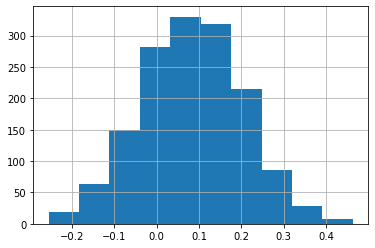

In [58]:
#hist = cosine_similarity_df['Cosine_similarity(w_t0,w_t1)'].hist()
# I display the last column of the data frame:
hist = cosine_similarity_dataframe("last", 0, models, intervals).iloc[:,-1].hist()

Now I can store the full time series of the cosine similarity between the embedding of a word in each time interval and the embedding of that same word in the reference interval (set to "last"):

In [59]:
intervals

[-450, 0, 450, 900]

In [180]:
reference_step = "last"
time_series = list()
reference_interval_index = find_reference_intervals(reference_step, intervals)
time_series_df = pd.DataFrame()
#for w in models[reference_interval_index].wv.index_to_key:
df = cosine_similarity_dataframe(reference_step, reference_interval_index, models, intervals)
df = df.sort_values('Word').reset_index(drop=True)
df

Word  Frequency_t_reference-last  Frequency_t2  \
0          !                         645           645   
1          '                        2828          2828   
2          (                         602           602   
3          )                         598           598   
4          -                        1741          1741   
...      ...                         ...           ...   
1493     vos                        1763          1763   
1494   votum                         162           162   
1495     vox                         657           657   
1496  vulnus                         252           252   
1497  vultus                         203           203   

      Cosine_similarity(w_t_reference-last,w_t2)  
0                                            1.0  
1                                            1.0  
2                                            1.0  
3                                            1.0  
4                                            1.0  
...                                          ...  
1493                                         1.0  
1494                                         1.0  
1495                                         1.0  
1496                                         1.0  
1497                                         1.0  

[1498 rows x 4 columns]

In [181]:
time_series_df[df.columns[0]] = df.iloc[:,0]
time_series_df[df.columns[1]] = df.iloc[:,1]
time_series_df

Word  Frequency_t_reference-last
0          !                         645
1          '                        2828
2          (                         602
3          )                         598
4          -                        1741
...      ...                         ...
1493     vos                        1763
1494   votum                         162
1495     vox                         657
1496  vulnus                         252
1497  vultus                         203

[1498 rows x 2 columns]

In [189]:
for i in range(len(models)):
    #print(reference_interval_index)
    print("Interval", str(intervals[i]), "with", str(list(intervals)[reference_interval_index]))
    df_i = cosine_similarity_dataframe(reference_step, i, models, intervals)
    df_i = df.sort_values('Word').reset_index(drop=True)
    #if i != reference_interval_index:
    tmp_df = df_i.iloc[:,-2:]
    #df.iloc[:,-2:].column[0]
    #print(df.iloc[:,0])
    time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
    time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
    col_i = "interval-"+str(i)
    time_series_df[col_i] = [i for w in models[reference_interval_index].wv.index_to_key]
    #Finding top 10 nearest neighbours:
    col_n = "neighbours_t"+str(i)
    #time_series_df[col_n] = [models[i].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
    time_series_df[col_n] = [models[i].wv.similar_by_word(w, 10) for w in df_i['Word']]
    print(time_series_df[time_series_df['Word']=='consul'])
    #else:
    #    tmp_df = df.iloc[:,-2:]
    #    #df.iloc[:,-2:].column[0]
    #    #print(df.iloc[:,0])
    #    time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
    #    time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
    #    col_i = "interval-"+str(i)
    #    time_series_df[col_i] = [i for w in models[reference_interval_index].wv.index_to_key]
    #    #Finding top 10 nearest neighbours:
    #    col_n = "neighbours_t"+str(i)
    #    time_series_df[col_n] = [models[i].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
    
time_series_df

Interval -450 with 450
       Word  Frequency_t_reference-last  Frequency_t0  \
284  consul                        1315           641   

     Cosine_similarity(w_t_reference-last,w_t0)  interval-0  \
284                                    0.183756           0   

                                         neighbours_t0  Frequency_t1  \
284  [(praetor, 0.7096078991889954), (Claudius, 0.5...          1254   

     Cosine_similarity(w_t_reference-last,w_t1)  interval-1  \
284                                    0.615719           1   

                                         neighbours_t1  Frequency_t2  \
284  [(A., 0.7804611921310425), (praetor, 0.6820345...          1315   

     Cosine_similarity(w_t_reference-last,w_t2)  interval-2  \
284                                         1.0           2   

                                         neighbours_t2  
284  [(patricius, 0.6986722350120544), (Pompeius, 0...  
Interval 0 with 450
       Word  Frequency_t_reference-last  Frequency_t0  \


Word  Frequency_t_reference-last  Frequency_t0  \
0          !                         645         48633   
1          '                        2828         32069   
2          (                         602         29166   
3          )                         598         28461   
4          -                        1741         23393   
...      ...                         ...           ...   
1493     vos                        1763           104   
1494   votum                         162           104   
1495     vox                         657           104   
1496  vulnus                         252           104   
1497  vultus                         203           104   

      Cosine_similarity(w_t_reference-last,w_t0)  interval-0  \
0                                       0.316767           0   
1                                       0.348807           0   
2                                       0.229145           0   
3                                       0.287714           0   
4                                       0.294113           0   
...                                          ...         ...   
1493                                    0.023241           0   
1494                                    0.011294           0   
1495                                   -0.005451           0   
1496                                    0.062690           0   
1497                                    0.117089           0   

                                          neighbours_t0  Frequency_t1  \
0     [(o, 0.5304742455482483), (pietas, 0.529646992...        122277   
1     [(inquiam, 0.5452851057052612), (immo, 0.51075...         92264   
2     [(), 0.5744660496711731), (erro, 0.45887386798...         66404   
3     [((, 0.5744659900665283), (immo, 0.54193401336...         58435   
4     [((, 0.3654758334159851), (appello, 0.36346855...         47648   
...                                                 ...           ...   
1493  [(vester, 0.6960850954055786), (iudex, 0.63577...           243   
1494  [(dedico, 0.6761938333511353), (templum, 0.607...           242   
1495  [(sonus, 0.6991795897483826), (vultus, 0.68224...           242   
1496  [(fames, 0.6343410611152649), (gladius, 0.6142...           242   
1497  [(auris, 0.8059790134429932), (sonus, 0.787140...           242   

      Cosine_similarity(w_t_reference-last,w_t1)  interval-1  \
0                                       0.741923           1   
1                                       0.795246           1   
2                                       0.776199           1   
3                                       0.809904           1   
4                                       0.769567           1   
...                                          ...         ...   
1493                                    0.558492           1   
1494                                    0.400749           1   
1495                                    0.178149           1   
1496                                    0.527533           1   
1497                                    0.365979           1   

                                          neighbours_t1  Frequency_t2  \
0     [(o, 0.5461975336074829), (pietas, 0.469734758...           645   
1     [(inquiam, 0.385995477437973), (quare, 0.37647...          2828   
2     [(etsi, 0.33213016390800476), (nomino, 0.30471...           602   
3     [(namque, 0.5529250502586365), (quamquam, 0.41...           598   
4     [(b, 0.361790269613266), (utique#2, 0.33880165...          1741   
...                                                 ...           ...   
1493  [(vester, 0.7128235101699829), (ego, 0.5914611...          1763   
1494  [(laetus, 0.5568166971206665), (gaudium, 0.547...           162   
1495  [(sonus, 0.593397319316864), (auris, 0.5623543...           657   
1496  [(tormentum, 0.6214414238929749), (dolor, 0.58...           252   
1497  [(pectus, 0.6313304305076599), (auris, 0.60157...           203   

      Cosine_simila

In [190]:
time_series_df[time_series_df['Word']=='consul']

Word  Frequency_t_reference-last  Frequency_t0  \
284  consul                        1315           641   

     Cosine_similarity(w_t_reference-last,w_t0)  interval-0  \
284                                    0.183756           0   

                                         neighbours_t0  Frequency_t1  \
284  [(praetor, 0.7096078991889954), (Claudius, 0.5...          1254   

     Cosine_similarity(w_t_reference-last,w_t1)  interval-1  \
284                                    0.615719           1   

                                         neighbours_t1  Frequency_t2  \
284  [(A., 0.7804611921310425), (praetor, 0.6820345...          1315   

     Cosine_similarity(w_t_reference-last,w_t2)  interval-2  \
284                                         1.0           2   

                                         neighbours_t2  
284  [(patricius, 0.6986722350120544), (Pompeius, 0...

Print to a file:

In [191]:
time_series_df.to_csv(os.path.join(dir_out, 'semantic_change_'+str(size_interval)+'_allwords.csv'), index=None)

In [192]:
time_series_df.columns

Index(['Word', 'Frequency_t_reference-last', 'Frequency_t0',
       'Cosine_similarity(w_t_reference-last,w_t0)', 'interval-0',
       'neighbours_t0', 'Frequency_t1',
       'Cosine_similarity(w_t_reference-last,w_t1)', 'interval-1',
       'neighbours_t1', 'Frequency_t2',
       'Cosine_similarity(w_t_reference-last,w_t2)', 'interval-2',
       'neighbours_t2'],
      dtype='object')

In [193]:
time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']]

interval-0  Cosine_similarity(w_t_reference-last,w_t0)
0              0                                    0.316767
1              0                                    0.348807
2              0                                    0.229145
3              0                                    0.287714
4              0                                    0.294113
...          ...                                         ...
1493           0                                    0.023241
1494           0                                    0.011294
1495           0                                   -0.005451
1496           0                                    0.062690
1497           0                                    0.117089

[1498 rows x 2 columns]

In [194]:
time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']].describe

<bound method NDFrame.describe of       interval-0  Cosine_similarity(w_t_reference-last,w_t0)
0              0                                    0.316767
1              0                                    0.348807
2              0                                    0.229145
3              0                                    0.287714
4              0                                    0.294113
...          ...                                         ...
1493           0                                    0.023241
1494           0                                    0.011294
1495           0                                   -0.005451
1496           0                                    0.062690
1497           0                                    0.117089

[1498 rows x 2 columns]>

In [195]:
time_series_df[['interval-1', 'Cosine_similarity(w_t_reference-last,w_t1)']]

interval-1  Cosine_similarity(w_t_reference-last,w_t1)
0              1                                    0.741923
1              1                                    0.795246
2              1                                    0.776199
3              1                                    0.809904
4              1                                    0.769567
...          ...                                         ...
1493           1                                    0.558492
1494           1                                    0.400749
1495           1                                    0.178149
1496           1                                    0.527533
1497           1                                    0.365979

[1498 rows x 2 columns]

In [196]:
time_series_df[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)'
               ]].iloc[0]

Cosine_similarity(w_t_reference-last,w_t0)    0.316767
Cosine_similarity(w_t_reference-last,w_t1)    0.741923
Name: 0, dtype: float64

In [197]:
px.line(time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']], 
        x = 'interval-0', y = 'Cosine_similarity(w_t_reference-last,w_t0)')

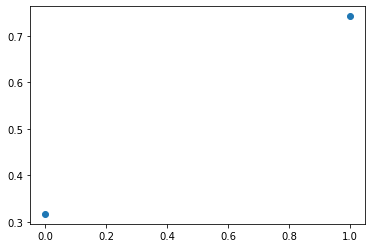

In [198]:
plt.scatter([0,1], 
            time_series_df[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)'
                           ]].iloc[0])
plt.show()

I rearrange the dataframe for visualization:

In [199]:
time_series_df.columns

Index(['Word', 'Frequency_t_reference-last', 'Frequency_t0',
       'Cosine_similarity(w_t_reference-last,w_t0)', 'interval-0',
       'neighbours_t0', 'Frequency_t1',
       'Cosine_similarity(w_t_reference-last,w_t1)', 'interval-1',
       'neighbours_t1', 'Frequency_t2',
       'Cosine_similarity(w_t_reference-last,w_t2)', 'interval-2',
       'neighbours_t2'],
      dtype='object')

In [200]:
time_series_df

Word  Frequency_t_reference-last  Frequency_t0  \
0          !                         645         48633   
1          '                        2828         32069   
2          (                         602         29166   
3          )                         598         28461   
4          -                        1741         23393   
...      ...                         ...           ...   
1493     vos                        1763           104   
1494   votum                         162           104   
1495     vox                         657           104   
1496  vulnus                         252           104   
1497  vultus                         203           104   

      Cosine_similarity(w_t_reference-last,w_t0)  interval-0  \
0                                       0.316767           0   
1                                       0.348807           0   
2                                       0.229145           0   
3                                       0.287714           0   
4                                       0.294113           0   
...                                          ...         ...   
1493                                    0.023241           0   
1494                                    0.011294           0   
1495                                   -0.005451           0   
1496                                    0.062690           0   
1497                                    0.117089           0   

                                          neighbours_t0  Frequency_t1  \
0     [(o, 0.5304742455482483), (pietas, 0.529646992...        122277   
1     [(inquiam, 0.5452851057052612), (immo, 0.51075...         92264   
2     [(), 0.5744660496711731), (erro, 0.45887386798...         66404   
3     [((, 0.5744659900665283), (immo, 0.54193401336...         58435   
4     [((, 0.3654758334159851), (appello, 0.36346855...         47648   
...                                                 ...           ...   
1493  [(vester, 0.6960850954055786), (iudex, 0.63577...           243   
1494  [(dedico, 0.6761938333511353), (templum, 0.607...           242   
1495  [(sonus, 0.6991795897483826), (vultus, 0.68224...           242   
1496  [(fames, 0.6343410611152649), (gladius, 0.6142...           242   
1497  [(auris, 0.8059790134429932), (sonus, 0.787140...           242   

      Cosine_similarity(w_t_reference-last,w_t1)  interval-1  \
0                                       0.741923           1   
1                                       0.795246           1   
2                                       0.776199           1   
3                                       0.809904           1   
4                                       0.769567           1   
...                                          ...         ...   
1493                                    0.558492           1   
1494                                    0.400749           1   
1495                                    0.178149           1   
1496                                    0.527533           1   
1497                                    0.365979           1   

                                          neighbours_t1  Frequency_t2  \
0     [(o, 0.5461975336074829), (pietas, 0.469734758...           645   
1     [(inquiam, 0.385995477437973), (quare, 0.37647...          2828   
2     [(etsi, 0.33213016390800476), (nomino, 0.30471...           602   
3     [(namque, 0.5529250502586365), (quamquam, 0.41...           598   
4     [(b, 0.361790269613266), (utique#2, 0.33880165...          1741   
...                                                 ...           ...   
1493  [(vester, 0.7128235101699829), (ego, 0.5914611...          1763   
1494  [(laetus, 0.5568166971206665), (gaudium, 0.547...           162   
1495  [(sonus, 0.593397319316864), (auris, 0.5623543...           657   
1496  [(tormentum, 0.6214414238929749), (dolor, 0.58...           252   
1497  [(pectus, 0.6313304305076599), (auris, 0.60157...           203   

      Cosine_simila

In [201]:
#time_series_df1 = pd.DataFrame(columns=['Time_interval', 'Cosine_sim', 'Word'])
time_series_df1 = pd.DataFrame()
for index, row in time_series_df.iterrows():
    #print(row['interval-0'], row['Cosine_similarity(w_t_reference-last,w_t0)'])
    
    #temp = pd.DataFrame(
    #    {
    #        'Time_interval': row['interval-0'],
    #        'Cosine_sim': row['Cosine_similarity(w_t_reference-last,w_t0)'],
    #        'Word': row['Word']
    #    }
    #)
    #print([row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']])
    #print(pd.DataFrame(
    #    [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]))
    time_series_df1 = pd.concat([time_series_df1, pd.DataFrame(
        [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]).transpose()])
    time_series_df1 = pd.concat([time_series_df1, pd.DataFrame(
        [row['interval-1'],row['Cosine_similarity(w_t_reference-last,w_t1)'],row['Word']]).transpose()])
    #print(time_series_df1)

time_series_df1.columns = ['Time_interval', 'Cosine_sim', 'Word']
time_series_df1

Time_interval Cosine_sim    Word
0              0   0.316767       !
0              1   0.741923       !
0              0   0.348807       '
0              1   0.795246       '
0              0   0.229145       (
..           ...        ...     ...
0              1   0.178149     vox
0              0    0.06269  vulnus
0              1   0.527533  vulnus
0              0   0.117089  vultus
0              1   0.365979  vultus

[2996 rows x 3 columns]

Print to output file:

In [202]:
time_series_df1.to_csv(os.path.join(dir_out, 'semantic_change1_'+str(size_interval)+'_allwords.csv'), index=None) 

List of socio-political terms:

In [203]:
socio_political_terms = ["civitas", "consilium", "consul", "dux", "gens", "hostis", "imperator", "jus", "labor", "natio", "nobilitas", "pontifex", "pontificium", "populus", "potestas", "regnum", "senatus", "sodes", "urbs"]

In [204]:
time_series_df_socpol = time_series_df[time_series_df['Word'].isin(socio_political_terms)]
time_series_df_socpol.to_csv(os.path.join(dir_out, 'semantic_change_'+str(size_interval)+'_socpolwords.csv'), index=None) 
time_series_df_socpol

Word  Frequency_t_reference-last  Frequency_t0  \
211     civitas                        1187           894   
275   consilium                         780           659   
284      consul                        1315           641   
427         dux                         692           419   
553        gens                         847           324   
583      hostis                        1217           302   
609   imperator                        2675           290   
703         jus                         883           247   
706       labor                         493           245   
834       natio                         158           209   
1011   pontifex                         162           165   
1012    populus                        1212           165   
1030   potestas                         632           162   
1175     regnum                         805           138   
1248    senatus                         952           130   
1422       urbs                        1576           111   

      Cosine_similarity(w_t_reference-last,w_t0)  interval-0  \
211                                    -0.040850           0   
275                                    -0.114317           0   
284                                     0.183756           0   
427                                     0.236237           0   
553                                     0.186637           0   
583                                     0.079120           0   
609                                     0.075236           0   
703                                     0.267309           0   
706                                     0.165823           0   
834                                     0.120244           0   
1011                                   -0.003553           0   
1012                                    0.112729           0   
1030                                    0.060400           0   
1175                                    0.172618           0   
1248                                   -0.004523           0   
1422                                    0.048994           0   

                                          neighbours_t0  Frequency_t1  \
211   [(gens, 0.5512999296188354), (libertas, 0.5442...          1640   
275   [(voluntas, 0.47594523429870605), (auctoritas,...          1282   
284   [(praetor, 0.7096078991889954), (Claudius, 0.5...          1254   
427   [(imperator, 0.6038288474082947), (adversus#2,...           849   
553   [(natio, 0.6782308220863342), (potens, 0.59168...           690   
583   [(pugno, 0.5515599846839905), (proelium, 0.504...           657   
609   [(dux, 0.6038287878036499), (triumphus, 0.4584...           624   
703   [(ius, 0.7495729327201843), (lex, 0.5872561931...           536   
706   [(patientia, 0.6043349504470825), (molestia, 0...           535   
834   [(gens, 0.6782307624816895), (socius, 0.593704...           452   
1011  [(dedico, 0.711566150188446), (Iulius, 0.68094...           369   
1012  [(populus#2, 0.754165768623352), (civis, 0.559...           369   
1030  [(arbitrium, 0.6611292362213135), (ditio, 0.62...           363   
1175  [(possessio, 0.5788851380348206), (ditio, 0.56...           317   
1248  [(decretum, 0.5429966449737549), (concilium, 0...           297   
1422  [(arx, 0.6330369114875793), (Capua, 0.57734036...           255   

      Cosine_similarity(w_t_reference-last,w_t1)  interval-1  \
211                                     0.630641           1   
275                                     0.526109           1   
284                                     0.615719           1   
427                                     0.469932           1   
553                                     0.629445           1   
583                                     0.669428           1   
609                                     0.614417           1   
703                                     0.541927           1   
706                                     0.639930           1   
83

In [205]:
time_series_df1_socpol = time_series_df1[time_series_df1['Word'].isin(socio_political_terms)]
time_series_df1_socpol.to_csv(os.path.join(dir_out, 'semantic_change1_'+str(size_interval)+'_socpolwords.csv'), index=None) 
time_series_df1_socpol

Time_interval Cosine_sim       Word
0             0   -0.04085    civitas
0             1   0.630641    civitas
0             0  -0.114317  consilium
0             1   0.526109  consilium
0             0   0.183756     consul
0             1   0.615719     consul
0             0   0.236237        dux
0             1   0.469932        dux
0             0   0.186637       gens
0             1   0.629445       gens
0             0    0.07912     hostis
0             1   0.669428     hostis
0             0   0.075236  imperator
0             1   0.614417  imperator
0             0   0.267309        jus
0             1   0.541927        jus
0             0   0.165823      labor
0             1    0.63993      labor
0             0   0.120244      natio
0             1   0.677684      natio
0             0  -0.003553   pontifex
0             1   0.534838   pontifex
0             0   0.112729    populus
0             1   0.244679    populus
0             0     0.0604   potestas
0             1   0.586492   potestas
0             0   0.172618     regnum
0             1   0.715547     regnum
0             0  -0.004523    senatus
0             1   0.662677    senatus
0             0   0.048994       urbs
0             1   0.542312       urbs

In [206]:
time_series_df1_socpol.dtypes

Time_interval    object
Cosine_sim       object
Word             object
dtype: object

In [207]:
time_series_df1_socpol["Time_interval"] = pd.to_numeric(time_series_df1_socpol["Time_interval"], downcast='integer')

<ipython-input-207-ff8e1f359109>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [208]:
time_series_df1_socpol["Cosine_sim"] = pd.to_numeric(time_series_df1_socpol["Cosine_sim"], downcast='float')

<ipython-input-208-4cd15d4c7cf8>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



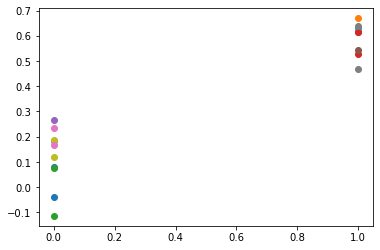

In [209]:
for i in range(len(socio_political_terms)):
    plt.scatter(time_series_df1_socpol[['Time_interval']].iloc[i], 
            time_series_df1_socpol[['Cosine_sim']].iloc[i])
plt.show()

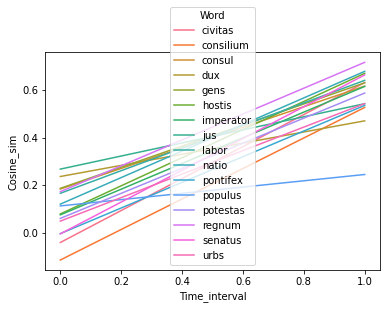

In [210]:
import seaborn as sns
#sns.lmplot('Time_interval', 'Cosine_sim', data=time_series_df_socpol, hue='Word', fit_reg=False)
sns.lineplot(x='Time_interval', y='Cosine_sim', data=time_series_df1_socpol, hue='Word', legend="full")
plt.show()

## Historiography subcorpus

I select by time period before 800CE and historical genre:

In [211]:
selected_texts = ['LAT0142', 'LAT0241', 'LAT0529', 'LAT0172', 'LAT0123', 'LAT0134', 'LAT0849', 'LAT0148', 'LAT0325', 'LAT0278', 'LAT1040', 'LAT1042', 'LAT0111', 'LAT0054', 'LAT0201', 'LAT0896', 'LAT0959', 'LAT0115', 'LAT0612', 'LAT0776', 'LAT0850', 'LAT0886', 'LAT0121', 'LAT0726', 'LAT0878', 'LAT0768', 'LAT0410', 'LAT0791', 'LAT0196', 'LAT0906', 'LAT0783', 'LAT0909']
selected_texts = ['IT-'+f for f in selected_texts]
selected_texts

['IT-LAT0142',
 'IT-LAT0241',
 'IT-LAT0529',
 'IT-LAT0172',
 'IT-LAT0123',
 'IT-LAT0134',
 'IT-LAT0849',
 'IT-LAT0148',
 'IT-LAT0325',
 'IT-LAT0278',
 'IT-LAT1040',
 'IT-LAT1042',
 'IT-LAT0111',
 'IT-LAT0054',
 'IT-LAT0201',
 'IT-LAT0896',
 'IT-LAT0959',
 'IT-LAT0115',
 'IT-LAT0612',
 'IT-LAT0776',
 'IT-LAT0850',
 'IT-LAT0886',
 'IT-LAT0121',
 'IT-LAT0726',
 'IT-LAT0878',
 'IT-LAT0768',
 'IT-LAT0410',
 'IT-LAT0791',
 'IT-LAT0196',
 'IT-LAT0906',
 'IT-LAT0783',
 'IT-LAT0909']

In [212]:
len(selected_texts)

32

In [213]:
#metadata_df_sel = pd.read_csv(os.path.join(dir_in, 'Metadata_selected_corpus.csv'), sep = ",")
#metadata_df_sel = metadata_df_sel[(metadata_df_sel['Selected for our study (1 or 0)'] == 1)
#                          & (metadata_df_sel['historical texts'] == 1)]
metadata_df_sel  = metadata_df[(metadata_df['id'].isin(selected_texts))]
metadata_df_sel.shape

(27, 7)

In [214]:
metadata_df_sel

id                                              title  \
41   IT-LAT0054                                     Vitae Caesarum   
69   IT-LAT0111                                Panegyricus Traiano   
72   IT-LAT0115                         Breviarium ab Urbe condita   
78   IT-LAT0121                               Rerum gestarum Libri   
89   IT-LAT0134                         De provinciis consularibus   
97   IT-LAT0142                                    Ab Urbe condita   
98   IT-LAT0148                                    Historia Romana   
118  IT-LAT0196                      De origine actibusque Getarum   
120  IT-LAT0201     Epitome Historiarum Philippicarum Pompei Trogi   
142  IT-LAT0241                                    De bello Africo   
166  IT-LAT0278                                         Res gestae   
182  IT-LAT0325                Historiarum Alexandri Magni libri X   
236  IT-LAT0410        Vita Sancti Martini episcopi et confessoris   
382  IT-LAT0612                                           Chronica   
451  IT-LAT0726                        Vita Malchi monachi captivi   
472  IT-LAT0768                            A Firmo de civitate Dei   
478  IT-LAT0776                                          Chronicon   
482  IT-LAT0783                                          Historiae   
490  IT-LAT0791                                          Chronicon   
535  IT-LAT0849                                Historica fragmenta   
536  IT-LAT0850                   De viris illustribus urbis Romae   
551  IT-LAT0878                                         Vita Pauli   
557  IT-LAT0886           Epistulae de iure civitatis Orcistenorum   
563  IT-LAT0896                              Vita Alexandri Severi   
572  IT-LAT0906  De summa temporum vel origine actibusque genti...   
575  IT-LAT0909  Historia de regibus Gothorum, Vandalorum et Su...   
611  IT-LAT0959                                              Vitae   

                                      creator  date   type  \
41               Svetonius Tranquillus, Caius   121  prose   
69           Plinius Gaius, Cecilius Secundus   100  prose   
72                                  Eutropius   350  prose   
78                       Ammianus Marcellinus   362  prose   
89                     Cicero, Marcus Tullius   -55  prose   
97                              Livius, Titus    -1  prose   
98                 Velleius Paterculus, Caius    29  prose   
118                                  Iordanes   550  prose   
120                 Iustinus Iunianus, Marcus   250  prose   
142                         [Auctor incertus]   -49  prose   
166  Augustus, Gaius Iulius Caesar Octavianus    13  prose   
182                    Curtius Rufus, Quintus    50  prose   
236                        Severus, Sulpicius   403  prose   
382                        Severus, Sulpicius   350  prose   
451                                Hieronymus   390  prose   
472                      Augustinus, Aurelius   419  prose   
478                       Hydatius Lemicensis   350  prose   
482                      Gregorius Turonensis   550  prose   
490                         Marcellinus Comes   550  prose   
535                     Actorius Naso, Marcus   -49  prose   
536        Auctor incertus (Aurelius Victor?)   350  prose   
551                                Hieronymus   400  prose   
557                                  Ablabius   330  prose   
563              Gargilius Martialis, Quintus   260  prose   
572                                  Iordanes   550  prose   
575            Isidorus Hispalensis Episcopus   598  prose   
611                     Cordus, Aelius Junius   250  prose   

                         file time_interval  
41    lat_0121_IT-LAT0054.txt             0  
69    lat_0100_IT-LAT0111.txt             0  
72    lat_0350_IT-LAT0115.txt             0  
78    lat_0362_IT-LAT0121.txt             0  
89   lat_-0055_IT-LAT0134.txt          -450  
97    lat_-001_IT-LAT0142.txt          

Define size of the time intervals:

In [215]:
size_interval = 450

So there are

In [216]:
n_intervals = round((last_date-first_date)/size_interval)
n_intervals

3

time intervals.

In [217]:
intervals = [None]*(n_intervals+1)
for t in range(n_intervals+1):
    #print(t)
    if t == 0:
        intervals[t] = first_date
    else:
        intervals[t] = intervals[t-1]+size_interval
    #print(intervals[t])
    
print(intervals)

[-450, 0, 450, 900]


Add a column to the metadata_df for the time interval:

In [218]:
metadata_df_sel['time_interval'] = ""
for t in range(len(intervals)-1):
    #print(t)
    #print(range(intervals[t],intervals[t+1]))
    metadata_df_sel_t = metadata_df_sel.loc[metadata_df_sel['date'].isin(range(intervals[t],intervals[t+1]))]
    #print(metadata_df_sel_t.date)
    metadata_df_sel.loc[metadata_df_sel['date'].isin(range(intervals[t],intervals[t+1])),'time_interval'] = intervals[t]
    #print(intervals[t])
metadata_df_sel

<ipython-input-218-fdf9a07fb554>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



id                                              title  \
41   IT-LAT0054                                     Vitae Caesarum   
69   IT-LAT0111                                Panegyricus Traiano   
72   IT-LAT0115                         Breviarium ab Urbe condita   
78   IT-LAT0121                               Rerum gestarum Libri   
89   IT-LAT0134                         De provinciis consularibus   
97   IT-LAT0142                                    Ab Urbe condita   
98   IT-LAT0148                                    Historia Romana   
118  IT-LAT0196                      De origine actibusque Getarum   
120  IT-LAT0201     Epitome Historiarum Philippicarum Pompei Trogi   
142  IT-LAT0241                                    De bello Africo   
166  IT-LAT0278                                         Res gestae   
182  IT-LAT0325                Historiarum Alexandri Magni libri X   
236  IT-LAT0410        Vita Sancti Martini episcopi et confessoris   
382  IT-LAT0612                                           Chronica   
451  IT-LAT0726                        Vita Malchi monachi captivi   
472  IT-LAT0768                            A Firmo de civitate Dei   
478  IT-LAT0776                                          Chronicon   
482  IT-LAT0783                                          Historiae   
490  IT-LAT0791                                          Chronicon   
535  IT-LAT0849                                Historica fragmenta   
536  IT-LAT0850                   De viris illustribus urbis Romae   
551  IT-LAT0878                                         Vita Pauli   
557  IT-LAT0886           Epistulae de iure civitatis Orcistenorum   
563  IT-LAT0896                              Vita Alexandri Severi   
572  IT-LAT0906  De summa temporum vel origine actibusque genti...   
575  IT-LAT0909  Historia de regibus Gothorum, Vandalorum et Su...   
611  IT-LAT0959                                              Vitae   

                                      creator  date   type  \
41               Svetonius Tranquillus, Caius   121  prose   
69           Plinius Gaius, Cecilius Secundus   100  prose   
72                                  Eutropius   350  prose   
78                       Ammianus Marcellinus   362  prose   
89                     Cicero, Marcus Tullius   -55  prose   
97                              Livius, Titus    -1  prose   
98                 Velleius Paterculus, Caius    29  prose   
118                                  Iordanes   550  prose   
120                 Iustinus Iunianus, Marcus   250  prose   
142                         [Auctor incertus]   -49  prose   
166  Augustus, Gaius Iulius Caesar Octavianus    13  prose   
182                    Curtius Rufus, Quintus    50  prose   
236                        Severus, Sulpicius   403  prose   
382                        Severus, Sulpicius   350  prose   
451                                Hieronymus   390  prose   
472                      Augustinus, Aurelius   419  prose   
478                       Hydatius Lemicensis   350  prose   
482                      Gregorius Turonensis   550  prose   
490                         Marcellinus Comes   550  prose   
535                     Actorius Naso, Marcus   -49  prose   
536        Auctor incertus (Aurelius Victor?)   350  prose   
551                                Hieronymus   400  prose   
557                                  Ablabius   330  prose   
563              Gargilius Martialis, Quintus   260  prose   
572                                  Iordanes   550  prose   
575            Isidorus Hispalensis Episcopus   598  prose   
611                     Cordus, Aelius Junius   250  prose   

                         file time_interval  
41    lat_0121_IT-LAT0054.txt             0  
69    lat_0100_IT-LAT0111.txt             0  
72    lat_0350_IT-LAT0115.txt             0  
78    lat_0362_IT-LAT0121.txt             0  
89   lat_-0055_IT-LAT0134.txt          -450  
97    lat_-001_IT-LAT0142.txt          

In [219]:
metadata_df_sel.describe

<bound method NDFrame.describe of              id                                              title  \
41   IT-LAT0054                                     Vitae Caesarum   
69   IT-LAT0111                                Panegyricus Traiano   
72   IT-LAT0115                         Breviarium ab Urbe condita   
78   IT-LAT0121                               Rerum gestarum Libri   
89   IT-LAT0134                         De provinciis consularibus   
97   IT-LAT0142                                    Ab Urbe condita   
98   IT-LAT0148                                    Historia Romana   
118  IT-LAT0196                      De origine actibusque Getarum   
120  IT-LAT0201     Epitome Historiarum Philippicarum Pompei Trogi   
142  IT-LAT0241                                    De bello Africo   
166  IT-LAT0278                                         Res gestae   
182  IT-LAT0325                Historiarum Alexandri Magni libri X   
236  IT-LAT0410        Vita Sancti Martini episcopi et c

Visualise distribution of time intervals:

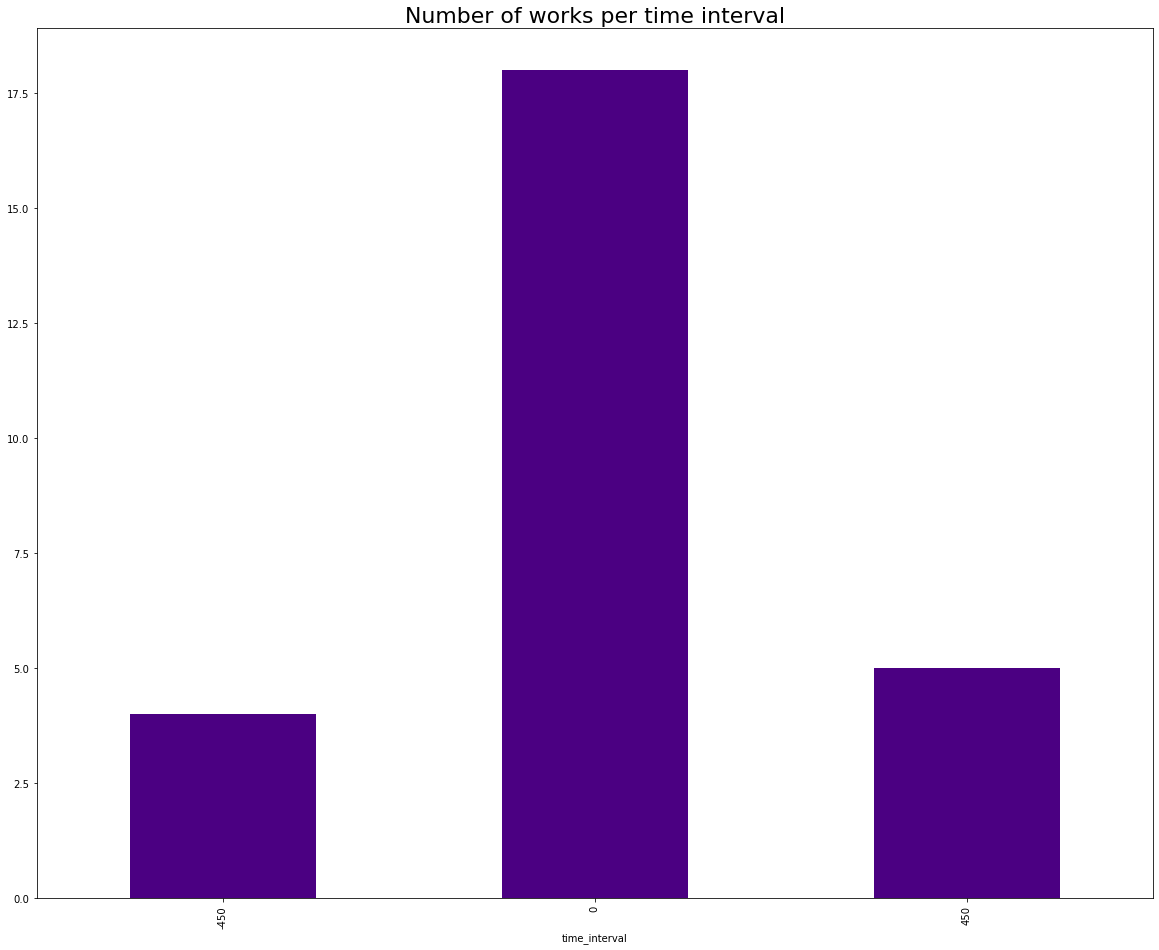

In [220]:
metadata_df0_sel = metadata_df_sel.groupby(['time_interval']).count()
metadata_df0_sel = metadata_df0_sel['id']
metadata_df0_sel
ax = metadata_df0_sel.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per time interval", fontsize=22)
plt.show()

There are:

In [221]:
n_intervals_sel = round((max(metadata_df_sel['time_interval'])-min(metadata_df_sel['time_interval']))/size_interval)
n_intervals_sel

2

in the historical subcorpus.

## Training embeddings for the whole subcorpus

#### Stopwords exclusion and further filtering


I create a list of lists, containing the tokens of each sentence in the whole corpus:

In [222]:
corpus_sel = list()
files_corpus_sel = metadata_df_sel
for index, df_line in files_corpus_sel.iterrows():
    #print("line:",df_line['id'], df_line['time_interval'])
    sign = "+"
    #print(df_line['date'])
    if df_line['date'] < 0:
        sign = "-"
    #print("date:", convert_dates(sign, abs(df_line['date'])))
    file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
    #print("3:",file_name)
    file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
    sentences_this_file = list()
    while True:
        line = file.readline().strip()
        if line != "":
            #sentences_this_file.append(line.split(" "))
            #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
            corpus_sel.append([token for token in line.split(" ") if token not in punctuation])
        # if line is empty end of file is reached
        if not line:
            break
    file.close()
corpus_sel.append(sentences_this_file)

In [223]:
corpus_sel

[['vita',
  'DIVI',
  'IVLI',
  'annus',
  'agens',
  'sextus',
  'decimus',
  'pater',
  'amitto',
  'sequentibusque',
  'consul',
  'flamen',
  'Dialis',
  'destinatus',
  'dimitto',
  'Cossutius',
  'quis#2',
  'familia',
  'equester',
  'sed',
  'admodum',
  'dives',
  'praetextatus',
  'desponsor',
  'sum',
  'Cornelius',
  'Cinna',
  'quater',
  'consul',
  'filia',
  'duco',
  'uxor',
  'ex',
  'qui',
  'ille',
  'mox',
  'Iulia',
  'nascor',
  'sum',
  'neque',
  'ut',
  'repudio',
  'compelli',
  'ab',
  'dictator',
  'Sulla',
  'ullus',
  'modus',
  'possum'],
 ['quare',
  'et',
  'sacerdotium',
  'et',
  'uxor',
  'dos',
  'et',
  'gentilicis',
  'hereditas',
  'multo',
  'diuersarum',
  'pars',
  'habeo',
  'ut',
  'etiam',
  'discedo',
  'ex',
  'medius',
  'et',
  'quamquam',
  'morbus',
  'quartana',
  'adgrauante',
  'prope',
  'per',
  'singulus',
  'nox',
  'commuto',
  'latebra',
  'cogo',
  'se',
  'ab',
  'inquisitoribus',
  'pecunia',
  'redimo',
  'donec',
  'per

In [224]:
metadata_df_sel

id                                              title  \
41   IT-LAT0054                                     Vitae Caesarum   
69   IT-LAT0111                                Panegyricus Traiano   
72   IT-LAT0115                         Breviarium ab Urbe condita   
78   IT-LAT0121                               Rerum gestarum Libri   
89   IT-LAT0134                         De provinciis consularibus   
97   IT-LAT0142                                    Ab Urbe condita   
98   IT-LAT0148                                    Historia Romana   
118  IT-LAT0196                      De origine actibusque Getarum   
120  IT-LAT0201     Epitome Historiarum Philippicarum Pompei Trogi   
142  IT-LAT0241                                    De bello Africo   
166  IT-LAT0278                                         Res gestae   
182  IT-LAT0325                Historiarum Alexandri Magni libri X   
236  IT-LAT0410        Vita Sancti Martini episcopi et confessoris   
382  IT-LAT0612                                           Chronica   
451  IT-LAT0726                        Vita Malchi monachi captivi   
472  IT-LAT0768                            A Firmo de civitate Dei   
478  IT-LAT0776                                          Chronicon   
482  IT-LAT0783                                          Historiae   
490  IT-LAT0791                                          Chronicon   
535  IT-LAT0849                                Historica fragmenta   
536  IT-LAT0850                   De viris illustribus urbis Romae   
551  IT-LAT0878                                         Vita Pauli   
557  IT-LAT0886           Epistulae de iure civitatis Orcistenorum   
563  IT-LAT0896                              Vita Alexandri Severi   
572  IT-LAT0906  De summa temporum vel origine actibusque genti...   
575  IT-LAT0909  Historia de regibus Gothorum, Vandalorum et Su...   
611  IT-LAT0959                                              Vitae   

                                      creator  date   type  \
41               Svetonius Tranquillus, Caius   121  prose   
69           Plinius Gaius, Cecilius Secundus   100  prose   
72                                  Eutropius   350  prose   
78                       Ammianus Marcellinus   362  prose   
89                     Cicero, Marcus Tullius   -55  prose   
97                              Livius, Titus    -1  prose   
98                 Velleius Paterculus, Caius    29  prose   
118                                  Iordanes   550  prose   
120                 Iustinus Iunianus, Marcus   250  prose   
142                         [Auctor incertus]   -49  prose   
166  Augustus, Gaius Iulius Caesar Octavianus    13  prose   
182                    Curtius Rufus, Quintus    50  prose   
236                        Severus, Sulpicius   403  prose   
382                        Severus, Sulpicius   350  prose   
451                                Hieronymus   390  prose   
472                      Augustinus, Aurelius   419  prose   
478                       Hydatius Lemicensis   350  prose   
482                      Gregorius Turonensis   550  prose   
490                         Marcellinus Comes   550  prose   
535                     Actorius Naso, Marcus   -49  prose   
536        Auctor incertus (Aurelius Victor?)   350  prose   
551                                Hieronymus   400  prose   
557                                  Ablabius   330  prose   
563              Gargilius Martialis, Quintus   260  prose   
572                                  Iordanes   550  prose   
575            Isidorus Hispalensis Episcopus   598  prose   
611                     Cordus, Aelius Junius   250  prose   

                         file time_interval  
41    lat_0121_IT-LAT0054.txt             0  
69    lat_0100_IT-LAT0111.txt             0  
72    lat_0350_IT-LAT0115.txt             0  
78    lat_0362_IT-LAT0121.txt             0  
89   lat_-0055_IT-LAT0134.txt          -450  
97    lat_-001_IT-LAT0142.txt          

In [225]:
metadata_df_sel.shape

(27, 7)

In [226]:
metadata_df_sel.describe

<bound method NDFrame.describe of              id                                              title  \
41   IT-LAT0054                                     Vitae Caesarum   
69   IT-LAT0111                                Panegyricus Traiano   
72   IT-LAT0115                         Breviarium ab Urbe condita   
78   IT-LAT0121                               Rerum gestarum Libri   
89   IT-LAT0134                         De provinciis consularibus   
97   IT-LAT0142                                    Ab Urbe condita   
98   IT-LAT0148                                    Historia Romana   
118  IT-LAT0196                      De origine actibusque Getarum   
120  IT-LAT0201     Epitome Historiarum Philippicarum Pompei Trogi   
142  IT-LAT0241                                    De bello Africo   
166  IT-LAT0278                                         Res gestae   
182  IT-LAT0325                Historiarum Alexandri Magni libri X   
236  IT-LAT0410        Vita Sancti Martini episcopi et c

Train FastText embeddings and, for full reproducibility, limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling:

In [227]:
start = time.time()
model_sel = FastText(vector_size=100, alpha=0.025, window=5, min_count=50, workers=1, seed=1, hashfxn=hash, max_n=0, 
                  sentences=corpus_sel)
end = time.time()
print("It has taken", round(end - start), "seconds")

It has taken 8 seconds


Let's see what words are similar to "dies":

In [228]:
model_sel.wv.similar_by_word('dies', 10)

[('triduum', 0.6318349838256836),
 ('hora', 0.6122906804084778),
 ('biduum', 0.6060689091682434),
 ('mensis', 0.6052747964859009),
 ('annus', 0.5935414433479309),
 ('tempus', 0.5623778700828552),
 ('nox', 0.5443812012672424),
 ('biennium', 0.5189014077186584),
 ('triennium', 0.4935615062713623),
 ('vigilia', 0.48966699838638306)]

## Training embeddings for each time interval

For each time interval, I read the texts from files and create a list of lists, i.e. a list of sentences:

In [229]:
intervals_sel = [None]*(n_intervals_sel+1)
for t in range(n_intervals_sel+1):
    print(t)
    if t == 0:
        intervals_sel[t] = min(metadata_df_sel['time_interval'])
    else:
        intervals_sel[t] = intervals_sel[t-1]+size_interval
    print(intervals_sel[t])
    
print(intervals_sel)

0
-450
1
0
2
450
[-450, 0, 450]


In [230]:
# dictionary that maps a time interval with the list of sentences of texts in that time interval"
time2corpus_sel = dict()

# I loop over all time intervals:
for t in range(n_intervals_sel+1):
    files_corpus_sel_t = metadata_df_sel.loc[metadata_df_sel['time_interval'] == intervals_sel[t]]
    print("1:",t, intervals_sel[t], "\n", files_corpus_sel_t, type(files_corpus_t))
    corpus_sel_t = list()
    for index, df_line in files_corpus_sel_t.iterrows():
        print("line:",df_line['id'], df_line['time_interval'])
        sign = "+"
        #print(df_line['date'])
        if df_line['date'] < 0:
            sign = "-"
        #print("date:", convert_dates(sign, abs(df_line['date'])))
        file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
        #print("3:",file_name)
        file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
        sentences_this_file = list()
        while True:
            line = file.readline().strip()
            if line != "":
                #sentences_this_file.append(line.split(" "))
                #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
                corpus_sel_t.append([token for token in line.split(" ") if token not in punctuation])
            # if line is empty end of file is reached
            if not line:
                break
        file.close()
        #corpus_t.append(sentences_this_file)
    #corpus_t1
    #print(len(corpus_t1[0]))
    time2corpus_sel[t] = corpus_sel_t


1: 0 -450 
              id                       title                 creator  date  \
89   IT-LAT0134  De provinciis consularibus  Cicero, Marcus Tullius   -55   
97   IT-LAT0142             Ab Urbe condita           Livius, Titus    -1   
142  IT-LAT0241             De bello Africo       [Auctor incertus]   -49   
535  IT-LAT0849         Historica fragmenta   Actorius Naso, Marcus   -49   

      type                      file time_interval  
89   prose  lat_-0055_IT-LAT0134.txt          -450  
97   prose   lat_-001_IT-LAT0142.txt          -450  
142  prose  lat_-0049_IT-LAT0241.txt          -450  
535  prose  lat_-0049_IT-LAT0849.txt          -450   <class 'pandas.core.frame.DataFrame'>
line: IT-LAT0134 -450
line: IT-LAT0142 -450
line: IT-LAT0241 -450
line: IT-LAT0849 -450
1: 1 0 
              id                                           title  \
41   IT-LAT0054                                  Vitae Caesarum   
69   IT-LAT0111                             Panegyricus Traiano   
7

In [231]:
time2corpus_sel

{0: [['de',
   'provincia',
   'consularis',
   'si',
   'quis#2',
   'vos',
   'pater',
   'conscribo',
   'exspecto',
   'quis#2',
   'sum',
   'provincia',
   'decerno',
   'considero',
   'ipse',
   'se',
   'cum',
   'quis#2',
   'ego',
   'homo',
   'ex',
   'provincia',
   'potissimus',
   'detraho',
   'sum',
   'non',
   'dubito',
   'quis#2',
   'sentio',
   'ego',
   'convenio',
   'cum',
   'quis#2',
   'ego',
   'sentio',
   'necesse',
   'sum',
   'cogitarit'],
  ['atque',
   'si',
   'princeps',
   'is',
   'sententia',
   'dico',
   'laudo',
   'profecto',
   'si',
   'solus',
   'certus',
   'ignosceritis',
   'etiamsi',
   'paulum',
   'parvus',
   'utilis',
   'vos',
   'sententia',
   'video',
   'venio',
   'tamen',
   'aliquis',
   'dolor',
   'meus',
   'tribuo'],
  ['nunc',
   'verus',
   'pater',
   'conscribo',
   'non',
   'parvus',
   'adficior',
   'voluptas',
   'vel',
   'quod',
   'hic',
   'multus',
   'reus',
   'publicus',
   'conduco',
   'Syria',
  

Let's inspect the corpus for the first time interval:

In [232]:
time2corpus_sel[0]

[['de',
  'provincia',
  'consularis',
  'si',
  'quis#2',
  'vos',
  'pater',
  'conscribo',
  'exspecto',
  'quis#2',
  'sum',
  'provincia',
  'decerno',
  'considero',
  'ipse',
  'se',
  'cum',
  'quis#2',
  'ego',
  'homo',
  'ex',
  'provincia',
  'potissimus',
  'detraho',
  'sum',
  'non',
  'dubito',
  'quis#2',
  'sentio',
  'ego',
  'convenio',
  'cum',
  'quis#2',
  'ego',
  'sentio',
  'necesse',
  'sum',
  'cogitarit'],
 ['atque',
  'si',
  'princeps',
  'is',
  'sententia',
  'dico',
  'laudo',
  'profecto',
  'si',
  'solus',
  'certus',
  'ignosceritis',
  'etiamsi',
  'paulum',
  'parvus',
  'utilis',
  'vos',
  'sententia',
  'video',
  'venio',
  'tamen',
  'aliquis',
  'dolor',
  'meus',
  'tribuo'],
 ['nunc',
  'verus',
  'pater',
  'conscribo',
  'non',
  'parvus',
  'adficior',
  'voluptas',
  'vel',
  'quod',
  'hic',
  'multus',
  'reus',
  'publicus',
  'conduco',
  'Syria',
  'Macedoniamque',
  'decerni',
  'ut',
  'dolor',
  'meus',
  'nihil',
  'ab',
  'c

And the second:

In [233]:
time2corpus_sel[1]

[['vita',
  'DIVI',
  'IVLI',
  'annus',
  'agens',
  'sextus',
  'decimus',
  'pater',
  'amitto',
  'sequentibusque',
  'consul',
  'flamen',
  'Dialis',
  'destinatus',
  'dimitto',
  'Cossutius',
  'quis#2',
  'familia',
  'equester',
  'sed',
  'admodum',
  'dives',
  'praetextatus',
  'desponsor',
  'sum',
  'Cornelius',
  'Cinna',
  'quater',
  'consul',
  'filia',
  'duco',
  'uxor',
  'ex',
  'qui',
  'ille',
  'mox',
  'Iulia',
  'nascor',
  'sum',
  'neque',
  'ut',
  'repudio',
  'compelli',
  'ab',
  'dictator',
  'Sulla',
  'ullus',
  'modus',
  'possum'],
 ['quare',
  'et',
  'sacerdotium',
  'et',
  'uxor',
  'dos',
  'et',
  'gentilicis',
  'hereditas',
  'multo',
  'diuersarum',
  'pars',
  'habeo',
  'ut',
  'etiam',
  'discedo',
  'ex',
  'medius',
  'et',
  'quamquam',
  'morbus',
  'quartana',
  'adgrauante',
  'prope',
  'per',
  'singulus',
  'nox',
  'commuto',
  'latebra',
  'cogo',
  'se',
  'ab',
  'inquisitoribus',
  'pecunia',
  'redimo',
  'donec',
  'per

And another one:

In [234]:
time2corpus_sel[2]

[['Praef'],
 ['Volentem',
  'ego',
  'parvus',
  'subveho',
  'navigium',
  'ora',
  'tranquillum',
  'litus#3',
  'stringo',
  'et',
  'minuo',
  'de',
  'priscus',
  'ut',
  'quidam',
  'ajo',
  'stagnum',
  'pisciculus',
  'lego#2',
  'in',
  'altus',
  'frater',
  'Castalius',
  'laxari',
  'velum',
  'compello',
  'relictoque',
  'opusculum',
  'quod',
  'intro',
  'manus',
  'habeo',
  'is',
  'sum',
  'de',
  'adbreviatione',
  'chronicus',
  'suadeo',
  'ut',
  'noster',
  'verbum',
  'duodecem',
  'senator',
  'volumen',
  'de',
  'origo',
  'actusque',
  'Geta',
  'ab',
  'olim',
  'et',
  'usque',
  'nunc',
  'per',
  'generatio',
  'regesque',
  'descendo',
  'in',
  'unus',
  'et',
  'hic',
  'parvus',
  'libellus',
  'choartem',
  'durus',
  'satis',
  'imperium',
  'et',
  'tamquam',
  'ab',
  'is',
  'quis#2',
  'pondus',
  'opus',
  'hic',
  'scio',
  'nollit',
  'inpono'],
 ['nec',
  'ille',
  'aspicio',
  'quod',
  'tenuis',
  'ego',
  'sum',
  'spiritus',
  'ad',
  

Following the findings of Sprugnoli et al. (2019) and Ribary & McGillivray (2020), for each time interval I train a fasttext model:

In [235]:
len(time2corpus_sel)

3

In [236]:
models_sel = list()
start = time.time()
for t in range(len(time2corpus_sel)):
    if len(time2corpus_sel[t])>0:
        print(t)
        #model = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
        model_sel = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1,hashfxn=hash, max_n=0)  # instantiate
        model_sel.build_vocab(corpus_iterable=time2corpus_sel[t])
        model_sel.train(corpus_iterable=time2corpus_sel[t], total_examples=len(time2corpus_sel[t]), epochs=10)  # train
        models_sel.append(model_sel)
        #model = fasttext.train_unsupervised(time2corpus[0][0], model='skipgram')
    else:
        models_sel.append("")
end = time.time()
print("It has taken", round(end - start), "seconds, or ", round((end - start)/60), "minutes")

0
1
2
It has taken 20 seconds, or  0 minutes


Let's check some models:

In [237]:
print_vocab(models_sel[0], 20)

word #0/6014 is sum
word #1/6014 is et
word #2/6014 is in
word #3/6014 is is
word #4/6014 is quis#2
word #5/6014 is ad
word #6/6014 is cum
word #7/6014 is ab
word #8/6014 is ut
word #9/6014 is se
word #10/6014 is Romanus
word #11/6014 is non
word #12/6014 is omnis
word #13/6014 is atque
word #14/6014 is ex
word #15/6014 is consul
word #16/6014 is hic
word #17/6014 is quam#4
word #18/6014 is res


In [238]:
print_vocab(models_sel[2], 20)

word #0/3696 is et
word #1/3696 is sum
word #2/3696 is in
word #3/3696 is is
word #4/3696 is quis#2
word #5/3696 is hic
word #6/3696 is cum
word #7/3696 is ad
word #8/3696 is ab
word #9/3696 is '
word #10/3696 is ut
word #11/3696 is rex
word #12/3696 is suus
word #13/3696 is ille
word #14/3696 is de
word #15/3696 is non
word #16/3696 is se
word #17/3696 is quod
word #18/3696 is sed


In [239]:
models_sel[0].wv.similar_by_word('dies', 10)

[('biduum', 0.6354857683181763),
 ('triduum', 0.5842409729957581),
 ('pridie', 0.5243738889694214),
 ('hora', 0.5241562724113464),
 ('mensis', 0.5080401301383972),
 ('annus', 0.49982401728630066),
 ('nox', 0.48723697662353516),
 ('quadriduum', 0.4473240375518799),
 ('Martius', 0.441005140542984),
 ('vigilia', 0.4406137466430664)]

In [240]:
models_sel[1].wv.similar_by_word('dies', 10)

[('hora', 0.7517405152320862),
 ('tempus', 0.7318995594978333),
 ('mensis', 0.7102551460266113),
 ('annus', 0.6925094127655029),
 ('ferus', 0.6356084942817688),
 ('nox', 0.606775164604187),
 ('lux', 0.6066621541976929),
 ('sextus', 0.6037611961364746),
 ('decimus', 0.6007608771324158),
 ('quintus', 0.5971499681472778)]

In [241]:
models_sel[2].wv.similar_by_word('dies', 10)

[('obeo', 0.8541436791419983),
 ('tempus', 0.8477525115013123),
 ('post', 0.8393341898918152),
 ('Catianus', 0.8379592299461365),
 ('Salvius', 0.8338721394538879),
 ('tertius', 0.8305975794792175),
 ('transitus', 0.8259282112121582),
 ('sepelio', 0.8153036832809448),
 ('sextus', 0.8075156807899475),
 ('ante', 0.8039541244506836)]

##  Embedding space alignment

I align all models:

In [242]:
from functools import reduce
#for t in range(len(models)):
#    smart_procrustes_align_gensim(models[t], models[0], words=None)
for i in range(0,len(models_sel)-1):
    reduce(smart_procrustes_align_gensim, [m for m in models_sel if m != ''])
    

4229 4229
4229 4229
['sum', 'et', 'in', 'quis#2', 'is', 'ad', 'cum', 'ut', 'ab', 'se', 'non', 'hic', 'omnis', 'atque', 'ex', 'quam#4', 'suus', 'Romanus', 'quod', 'ipse', 'per', 'res', 'sed', 'bellum', 'facio', 'rex', 'consul', 'nec', 'hostis', 'possum', 'alius', 'si', 'urbs', 'multus', 'habeo', 'dies', 'ille', 'ne#2', 'aut', 'primus', 'de', 'etiam', 'exercitus', 'iam', 'do', 'magnus', 'miles', 'idem', 'inter', 'castrum', 'quoque', 'mitto', 'video', 'mille', '-', 'ita', 'quo', 'venio', 'senatus', 'annus', 'pars', 'dico#2', 'locus', 'qui', 'deinde', 'unus', 'pater', 'animus', 'inde', 'tum', 'tempus', 'post', 'ante', 'duo', 'tantus', 'legatus', 'pro', 'quidam', 'tamen', 'modus', 'ago', 'imperium', 'ego', 'eques', 'neque', 'publicus', 'capio', 'quidem', 'enim', 'ubi', 'vis', 'nihil', 'populus', 'causa', 'deus', ']', '[', 'accipio', 'Roma', "'", 'nullus', 'dux', 'arma', 'civitas', 'plebs', 'peto', 'homo', 'nomen', 'filius', 'fero', 'ager', 'tribunus', 'acies', 'M.', 'verus', 'quos', 'itaque

2194 2194
2194 2194
['sum', 'et', 'in', 'quis#2', 'is', 'ad', 'cum', 'ut', 'ab', 'hic', 'se', 'non', 'suus', 'atque', 'quod', 'rex', 'omnis', 'ipse', 'ex', 'per', 'quam#4', 'sed', 'Romanus', "'", 'ille', 'de', 'res', 'facio', 'urbs', 'nec', 'bellum', 'dico#2', 'multus', 'si', 'alius', 'possum', 'habeo', 'consul', 'dies', 'qui', 'hostis', 'verus', 'annus', 'exercitus', 'magnus', 'aut', 'iam', 'ego', 'ne#2', 'primus', 'post', 'etiam', 'venio', 'do', 'enim', 'inter', 'quoque', 'idem', 'video', 'mitto', 'autem', 'locus', 'quo', 'filius', 'ita', 'deus', 'unus', 'pater', 'pars', 'tempus', 'pro', 'castrum', 'miles', 'mille', 'tantus', 'quidam', '-', 'regnum', 'tamen', 'ago', 'populus', 'civitas', 'ante', 'duo', 'accipio', 'imperium', 'quia', 'senatus', 'deinde', 'animus', 'legatus', 'causa', 'vel', 'homo', 'nihil', 'ubi', 'inde', 'publicus', 'nomen', 'modus', 'tum', 'gens', 'nullus', 'quidem', 'dux', 'apud', 'vir', 'neque', 'capio', 'tunc', 'vis', 'Roma', 'eques', ']', 'nos', '[', 'fero', 'pe

2194 2194
2194 2194
['sum', 'et', 'in', 'quis#2', 'is', 'ad', 'cum', 'ut', 'ab', 'se', 'hic', 'non', 'atque', 'omnis', 'suus', 'ex', 'quod', 'quam#4', 'ipse', 'per', 'Romanus', 'rex', 'sed', 'res', 'facio', 'bellum', 'nec', 'ille', 'urbs', 'consul', 'de', 'possum', 'alius', 'multus', 'hostis', 'si', 'habeo', 'dies', 'aut', 'exercitus', 'ne#2', 'primus', 'iam', 'etiam', 'magnus', 'do', "'", 'dico#2', 'idem', 'inter', 'quoque', 'qui', 'miles', 'annus', 'mitto', 'video', 'castrum', 'venio', 'quo', 'post', 'ita', 'locus', 'mille', '-', 'unus', 'pars', 'pater', 'ego', 'senatus', 'tempus', 'deinde', 'enim', 'verus', 'animus', 'tantus', 'ante', 'pro', 'inde', 'duo', 'quidam', 'tum', 'tamen', 'ago', 'deus', 'legatus', 'imperium', 'populus', 'filius', 'modus', 'civitas', 'accipio', 'ubi', 'publicus', 'causa', 'nihil', 'quidem', 'neque', 'capio', 'eques', 'vis', 'homo', 'nullus', ']', 'regnum', 'autem', '[', 'dux', 'quia', 'Roma', 'nomen', 'arma', 'peto', 'gens', 'fero', 'plebs', 'quos', 'vel', 

Now the models have been aligned and have the same vocabulary:

In [243]:
for i in range(0,len(models_sel)):
    if models_sel[i] != '':
        print(i, len(models_sel[i].wv.index_to_key))

0 2194
1 2194
2 2194


# Semantic change with cosine similarity

In [244]:
intervals_sel

[-450, 0, 450]

In [245]:
models_sel

In [246]:
reference_interval_index = find_reference_intervals("last", intervals_sel)
reference_interval_index

1

In [247]:
models_sel[2].wv["sum"]

array([ 0.1124827 ,  0.220336  , -0.46877754,  0.05850657,  0.14329837,
       -0.3312018 ,  0.68753153,  0.22279681, -0.7437605 , -0.04981296,
       -0.09114923, -0.00948638,  0.2977872 ,  0.09877191,  0.14069958,
       -0.52188766,  0.505085  , -0.19396625, -0.34137914, -0.41942105,
        0.60160035,  0.04527513,  0.29177904,  0.04542215, -0.35216713,
       -0.31170112,  0.03823782,  0.04150841, -0.29545277, -0.14289543,
       -0.02205387, -0.48220962,  0.11871244, -0.14508426, -0.44141427,
        0.14596428,  0.20373432,  0.08529276,  0.02661579, -0.26270512,
       -0.19800621, -0.17529409,  0.23128608, -0.02955355,  0.46824184,
        0.27495652, -0.5391233 , -0.13276514,  0.17436442, -0.00814766,
        0.24231617,  0.10203093,  0.33333087, -0.39949256, -0.11239183,
       -0.02639816, -0.40412065, -0.15401597, -0.6325622 , -0.13377889,
        0.26089287,  0.09800407, -0.0360496 , -0.20933032, -0.4746173 ,
        0.5698929 ,  0.18330657,  0.14961185, -0.38576153,  0.40

In [248]:
reference_interval_index = find_reference_intervals("last", intervals_sel)
reference_interval_index
#cosine_similarity("sum", 4, "last", models_sel)

1

In [249]:
cosine_similarity("sum", 2, "first", models_sel, intervals_sel)

0.6252708435058594

In [250]:
models_sel

In [251]:
cosine_similarity_dataframe("last", 0, models_sel, intervals_sel)

Word  Frequency_t_reference-last  Frequency_t0  \
0             sum                       13046         17478   
1              et                        9810         12820   
2              in                        8620         12602   
3          quis#2                        7296          9355   
4              is                        5741          8096   
...           ...                         ...           ...   
2189  providentia                          28            24   
2190        purum                          28            24   
2191     excelsum                          28            24   
2192       surdus                          28            24   
2193       evello                          28            24   

      Cosine_similarity(w_t_reference-last,w_t0)  
0                                       0.829408  
1                                       0.733766  
2                                       0.760881  
3                                       0.836112  
4                                       0.797545  
...                                          ...  
2189                                    0.868582  
2190                                    0.786741  
2191                                    0.813754  
2192                                    0.921419  
2193                                    0.861668  

[2194 rows x 4 columns]

In [252]:
cosine_similarity_dataframe("first", 2, models_sel, intervals_sel)

Word  Frequency_t_reference-first  Frequency_t2  \
0             sum                        17478          4392   
1              et                        12820          4233   
2              in                        12602          3968   
3          quis#2                         9355          3128   
4              is                         8096          3048   
...           ...                          ...           ...   
2189   laudabilis                           24             9   
2190  venerabilis                           24             9   
2191       evello                           24             9   
2192     excelsum                           24             9   
2193       surdus                           24             9   

      Cosine_similarity(w_t_reference-first,w_t2)  
0                                        0.625271  
1                                        0.433842  
2                                        0.461133  
3                                        0.475889  
4                                        0.577217  
...                                           ...  
2189                                     0.895051  
2190                                     0.786623  
2191                                     0.820336  
2192                                     0.842457  
2193                                     0.887601  

[2194 rows x 4 columns]

Visualise the distribution of the semantic similarity scores with a histogram:

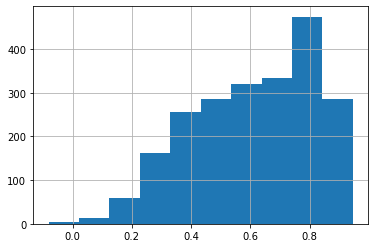

In [253]:
#hist = cosine_similarity_df['Cosine_similarity(w_t0,w_t1)'].hist()
# I display the last column of the data frame:
hist = cosine_similarity_dataframe("first", 2, models_sel, intervals_sel).iloc[:,-1].hist()

Now I can store the full time series of the cosine similarity between the embedding of a word in each time interval and the embedding of that same word in the reference interval (set to "last"):

In [254]:
intervals

[-450, 0, 450, 900]

In [255]:
reference_step = "last"
time_series = list()
reference_interval_index = find_reference_intervals(reference_step, intervals)
time_series_df_sel = pd.DataFrame()
#for w in models[reference_interval_index].wv.index_to_key:
df = cosine_similarity_dataframe(reference_step, reference_interval_index, models_sel, intervals_sel)
time_series_df_sel[df.columns[0]] = df.iloc[:,0]
time_series_df_sel[df.columns[1]] = df.iloc[:,1]
for i in range(len(models_sel)):
    #print(reference_interval_index)
    print("Interval", str(intervals_sel[i]), "with", str(list(intervals_sel)[reference_interval_index]))
    df = cosine_similarity_dataframe(reference_step, i, models_sel, intervals_sel)
#    if i == reference_interval_index:
#        time_series_df = df
#        col_i = "interval-"+str(reference_interval_index)
#        time_series_df[col_i] = [reference_interval_index for w in models[reference_interval_index].wv.index_to_key]
#        col_n = "neighbours_ref-"+reference_step
#        time_series_df[col_n] = [models[reference_interval_index].wv.similar_by_word(w, 10) for w in models[reference_interval_index].wv.index_to_key]
#    else:
#        #time_series_df = time_series_df, df.iloc[:,-2:]
#        tmp_df = df.iloc[:,-2:]
#        #df.iloc[:,-2:].column[0]
#        #print(tmp_df.iloc[:,0])
#        time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
#        time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
#        col_i = "interval-"+str(i)
#        time_series_df[col_i] = [i for w in models[reference_interval_index].wv.index_to_key]
#        #Finding top 10 nearest neighbours:
#        col_n = "neighbours_t"+str(i)
#        time_series_df[col_n] = [models[i].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
    if i != reference_interval_index:
        tmp_df = df.iloc[:,-2:]
        #df.iloc[:,-2:].column[0]
        #print(df.iloc[:,0])
        time_series_df_sel[tmp_df.columns[0]] = tmp_df.iloc[:,0]
        time_series_df_sel[tmp_df.columns[1]] = tmp_df.iloc[:,1]
        col_i = "interval-"+str(i)
        time_series_df_sel[col_i] = [i for w in models_sel[reference_interval_index].wv.index_to_key]
        #Finding top 10 nearest neighbours:
        col_n = "neighbours_t"+str(i)
        time_series_df_sel[col_n] = [models_sel[i].wv.similar_by_word(w, 10) for w in models_sel[i].wv.index_to_key]
        #print(time_series_df)
    else:
        tmp_df = df.iloc[:,-2:]
        #df.iloc[:,-2:].column[0]
        #print(df.iloc[:,0])
        time_series_df_sel[tmp_df.columns[0]] = tmp_df.iloc[:,0]
        time_series_df_sel[tmp_df.columns[1]] = tmp_df.iloc[:,1]
        col_i = "interval-"+str(i)
        time_series_df_sel[col_i] = [i for w in models_sel[reference_interval_index].wv.index_to_key]
        #Finding top 10 nearest neighbours:
        col_n = "neighbours_t"+str(i)
        time_series_df_sel[col_n] = [models_sel[i].wv.similar_by_word(w, 10) for w in models_sel[i].wv.index_to_key]
    
time_series_df_sel

Interval -450 with 450
Interval 0 with 450
Interval 450 with 450


Word  Frequency_t_reference-last  Frequency_t0  \
0             sum                       13046         17478   
1              et                        9810         12820   
2              in                        8620         12602   
3          quis#2                        7296          9355   
4              is                        5741          8096   
...           ...                         ...           ...   
2189   laudabilis                          28            24   
2190  venerabilis                          28            24   
2191       evello                          28            24   
2192     excelsum                          28            24   
2193       surdus                          28            24   

      Cosine_similarity(w_t_reference-last,w_t0)  interval-0  \
0                                       0.829408           0   
1                                       0.733766           0   
2                                       0.760881           0   
3                                       0.836112           0   
4                                       0.797545           0   
...                                          ...         ...   
2189                                    0.868582           0   
2190                                    0.786741           0   
2191                                    0.813754           0   
2192                                    0.921419           0   
2193                                    0.861668           0   

                                          neighbours_t0  Frequency_t1  \
0     [(habeo, 0.5508652925491333), (fio, 0.43321719...         13046   
1     [(impono, 0.49507302045822144), (misceo, 0.464...          9810   
2     [(ex, 0.6414998769760132), (extra, 0.579670786...          8620   
3     [(quod, 0.6069824695587158), (quo, 0.551809430...          7296   
4     [(dico, 0.5746298432350159), (prior, 0.4825229...          5741   
...                                                 ...           ...   
2189  [(dens, 0.904628336429596), (infans, 0.9031747...            28   
2190  [(scortum, 0.8728049397468567), (diligens, 0.8...            28   
2191  [(obsero, 0.8799669146537781), (pasco, 0.87314...            28   
2192  [(mediocris, 0.9195466041564941), (lenis, 0.89...            28   
2193  [(cuneus, 0.8662706017494202), (provolvo, 0.85...            28   

      Cosine_similarity(w_t_reference-last,w_t1)  interval-1  \
0                                            1.0           1   
1                                            1.0           1   
2                                            1.0           1   
3                                            1.0           1   
4                                            1.0           1   
...                                          ...         ...   
2189                                         1.0           1   
2190                                         1.0           1   
2191                                         1.0           1   
2192                                         1.0           1   
2193                                         1.0           1   

                                          neighbours_t1  Frequency_t2  \
0     [(habeo, 0.6579799056053162), (evenio, 0.59964...          4392   
1     [(eximius, 0.6165882349014282), (aureus, 0.596...          4233   
2     [(sub, 0.6588958501815796), (circa, 0.63119810...          3968   
3     [(quod, 0.7420827746391296), (quos, 0.71383255...          3128   
4     [(superus, 0.6412000060081482), (suus, 0.63484...          3048   
...                                                 ...           ...   
2189  [(placo, 0.9663680195808411), (poto, 0.9644926...             9   
2190  [(sonus, 0.9559711217880249), (naturalis, 0.95...             9   
2191  [(cano, 0.9740927219390869), (aliquamdiu, 0.97...             9   
2192  [(pristinus, 0.9651336669921875), (abnuo, 0.96...             9   
2193  [(iacio, 0.9571107625961304), (f

Print to a file:

In [256]:
time_series_df_sel.to_csv(os.path.join(dir_out, 'semantic_change_histcorpus_'+str(size_interval)+'_allwords.csv'), index=None)

In [257]:
px.line(time_series_df_sel[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']], 
        x = 'interval-0', y = 'Cosine_similarity(w_t_reference-last,w_t0)')

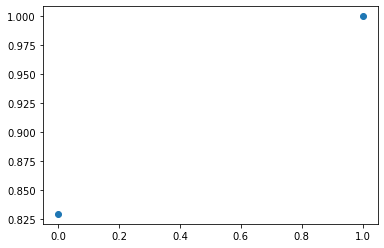

In [258]:
plt.scatter([0,1], 
            time_series_df_sel[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)'
                           ]].iloc[0])
plt.show()

I rearrange the dataframe for visualization:

In [259]:
time_series_df_sel.columns

Index(['Word', 'Frequency_t_reference-last', 'Frequency_t0',
       'Cosine_similarity(w_t_reference-last,w_t0)', 'interval-0',
       'neighbours_t0', 'Frequency_t1',
       'Cosine_similarity(w_t_reference-last,w_t1)', 'interval-1',
       'neighbours_t1', 'Frequency_t2',
       'Cosine_similarity(w_t_reference-last,w_t2)', 'interval-2',
       'neighbours_t2'],
      dtype='object')

In [260]:
time_series_df_sel

Word  Frequency_t_reference-last  Frequency_t0  \
0             sum                       13046         17478   
1              et                        9810         12820   
2              in                        8620         12602   
3          quis#2                        7296          9355   
4              is                        5741          8096   
...           ...                         ...           ...   
2189   laudabilis                          28            24   
2190  venerabilis                          28            24   
2191       evello                          28            24   
2192     excelsum                          28            24   
2193       surdus                          28            24   

      Cosine_similarity(w_t_reference-last,w_t0)  interval-0  \
0                                       0.829408           0   
1                                       0.733766           0   
2                                       0.760881           0   
3                                       0.836112           0   
4                                       0.797545           0   
...                                          ...         ...   
2189                                    0.868582           0   
2190                                    0.786741           0   
2191                                    0.813754           0   
2192                                    0.921419           0   
2193                                    0.861668           0   

                                          neighbours_t0  Frequency_t1  \
0     [(habeo, 0.5508652925491333), (fio, 0.43321719...         13046   
1     [(impono, 0.49507302045822144), (misceo, 0.464...          9810   
2     [(ex, 0.6414998769760132), (extra, 0.579670786...          8620   
3     [(quod, 0.6069824695587158), (quo, 0.551809430...          7296   
4     [(dico, 0.5746298432350159), (prior, 0.4825229...          5741   
...                                                 ...           ...   
2189  [(dens, 0.904628336429596), (infans, 0.9031747...            28   
2190  [(scortum, 0.8728049397468567), (diligens, 0.8...            28   
2191  [(obsero, 0.8799669146537781), (pasco, 0.87314...            28   
2192  [(mediocris, 0.9195466041564941), (lenis, 0.89...            28   
2193  [(cuneus, 0.8662706017494202), (provolvo, 0.85...            28   

      Cosine_similarity(w_t_reference-last,w_t1)  interval-1  \
0                                            1.0           1   
1                                            1.0           1   
2                                            1.0           1   
3                                            1.0           1   
4                                            1.0           1   
...                                          ...         ...   
2189                                         1.0           1   
2190                                         1.0           1   
2191                                         1.0           1   
2192                                         1.0           1   
2193                                         1.0           1   

                                          neighbours_t1  Frequency_t2  \
0     [(habeo, 0.6579799056053162), (evenio, 0.59964...          4392   
1     [(eximius, 0.6165882349014282), (aureus, 0.596...          4233   
2     [(sub, 0.6588958501815796), (circa, 0.63119810...          3968   
3     [(quod, 0.7420827746391296), (quos, 0.71383255...          3128   
4     [(superus, 0.6412000060081482), (suus, 0.63484...          3048   
...                                                 ...           ...   
2189  [(placo, 0.9663680195808411), (poto, 0.9644926...             9   
2190  [(sonus, 0.9559711217880249), (naturalis, 0.95...             9   
2191  [(cano, 0.9740927219390869), (aliquamdiu, 0.97...             9   
2192  [(pristinus, 0.9651336669921875), (abnuo, 0.96...             9   
2193  [(iacio, 0.9571107625961304), (f

In [261]:
#time_series_df1 = pd.DataFrame(columns=['Time_interval', 'Cosine_sim', 'Word'])
time_series_df1_sel = pd.DataFrame()
for index, row in time_series_df_sel.iterrows():
    #print(row['interval-0'], row['Cosine_similarity(w_t_reference-last,w_t0)'])
    
    #temp = pd.DataFrame(
    #    {
    #        'Time_interval': row['interval-0'],
    #        'Cosine_sim': row['Cosine_similarity(w_t_reference-last,w_t0)'],
    #        'Word': row['Word']
    #    }
    #)
    #print([row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']])
    #print(pd.DataFrame(
    #    [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]))
    time_series_df1_sel = pd.concat([time_series_df1_sel, pd.DataFrame(
        [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]).transpose()])
    time_series_df1_sel = pd.concat([time_series_df1_sel, pd.DataFrame(
        [row['interval-1'],row['Cosine_similarity(w_t_reference-last,w_t1)'],row['Word']]).transpose()])
    #print(time_series_df1_sel)

time_series_df1_sel.columns = ['Time_interval', 'Cosine_sim', 'Word']
time_series_df1_sel

Time_interval Cosine_sim      Word
0              0   0.829408       sum
0              1        1.0       sum
0              0   0.733766        et
0              1        1.0        et
0              0   0.760881        in
..           ...        ...       ...
0              1        1.0    evello
0              0   0.921419  excelsum
0              1        1.0  excelsum
0              0   0.861668    surdus
0              1        1.0    surdus

[4388 rows x 3 columns]

Print to output file:

In [262]:
time_series_df1_sel.to_csv(os.path.join(dir_out, 'semantic_change1_histcorpus_'+str(size_interval)+'_allwords.csv'), index=None) 

List of socio-political terms:

In [263]:
socio_political_terms = ["civitas", "consilium", "consul", "dux", "gens", "hostis", "imperator", "jus", "labor", "natio", "nobilitas", "pontifex", "pontificium", "populus", "potestas", "regnum", "senatus", "sodes", "urbs"]

In [264]:
time_series_df_socpol_sel = time_series_df_sel[time_series_df_sel['Word'].isin(socio_political_terms)]
time_series_df_socpol_sel.to_csv(os.path.join(dir_out, 'semantic_change_histcorpus_'+str(size_interval)+'_socpolwords.csv'), index=None) 
time_series_df_socpol_sel

Word  Frequency_t_reference-last  Frequency_t0  \
28         urbs                        1280          1936   
37       consul                        1220          1599   
40       hostis                        1071          1556   
77       regnum                         510           954   
80      populus                         619           923   
81      civitas                         589           914   
87      senatus                         719           874   
101        gens                         478           794   
104         dux                         501           784   
129   imperator                         385           632   
137   consilium                         424           589   
225    potestas                         259           373   
324         jus                         208           258   
406       labor                         158           195   
783    pontifex                          72            98   
900       natio                          69            85   
1309  nobilitas                          53            52   

      Cosine_similarity(w_t_reference-last,w_t0)  interval-0  \
28                                      0.689820           0   
37                                      0.777498           0   
40                                      0.859876           0   
77                                      0.703082           0   
80                                      0.642759           0   
81                                      0.768548           0   
87                                      0.760189           0   
101                                     0.781050           0   
104                                     0.502838           0   
129                                     0.735443           0   
137                                     0.618472           0   
225                                     0.831798           0   
324                                     0.517912           0   
406                                     0.510175           0   
783                                     0.818371           0   
900                                     0.588691           0   
1309                                    0.663324           0   

                                          neighbours_t0  Frequency_t1  \
28    [(arx, 0.6756952404975891), (oppidum, 0.672359...          1280   
37    [(triduum, 0.5842409729957581), (hora, 0.52415...          1049   
40    [(ne, 0.7721870541572571), (si, 0.501615047454...           989   
77    [(protinus, 0.6161934733390808), (clam, 0.5616...           668   
80    [(increpo, 0.4332702159881592), (accensus, 0.4...           658   
81    [(tam, 0.7052959203720093), (etsi, 0.700980722...           657   
87    [(frater, 0.8710088729858398), (uxor, 0.780504...           610   
101   [(numquam, 0.7440369725227356), (ullus, 0.7122...           535   
104   [(-, 0.7927884459495544), (enim, 0.78285992145...           507   
129   [(ego, 0.8727334141731262), (nos, 0.8707118630...           427   
137   [(pes, 0.7442732453346252), (cano, 0.695134222...           408   
225   [(nobilitas, 0.796567976474762), (dignitas, 0....           249   
324   [(censeo, 0.7869428396224976), (mandatum, 0.74...           190   
406   [(quantus, 0.7169100046157837), (utor, 0.61111...           154   
783   [(maiestas, 0.9166349172592163), (meritum, 0.8...            86   
900   [(fructus, 0.8222156167030334), (eoque, 0.7635...            75   
1309  [(uxor, 0.8106936812400818), (mater, 0.7886812...            50   

      Cosine_similarity(w_t_reference-last,w_t1)  interval-1  \
28                                           1.0           1   
37                                           1.0           1   
40                                           1.0           1   
77                                           1.0           1   
80                                           1.0           1   
81                                           1.0           1

In [265]:
time_series_df1_socpol_sel = time_series_df1_sel[time_series_df1_sel['Word'].isin(socio_political_terms)]
time_series_df1_socpol_sel.to_csv(os.path.join(dir_out, 'semantic_change1_histcorpus_'+str(size_interval)+'_socpolwords.csv'), index=None) 
time_series_df1_socpol_sel

Time_interval Cosine_sim       Word
0             0    0.68982       urbs
0             1        1.0       urbs
0             0   0.777498     consul
0             1        1.0     consul
0             0   0.859876     hostis
0             1        1.0     hostis
0             0   0.703082     regnum
0             1        1.0     regnum
0             0   0.642759    populus
0             1        1.0    populus
0             0   0.768548    civitas
0             1        1.0    civitas
0             0   0.760189    senatus
0             1        1.0    senatus
0             0    0.78105       gens
0             1        1.0       gens
0             0   0.502838        dux
0             1        1.0        dux
0             0   0.735443  imperator
0             1        1.0  imperator
0             0   0.618472  consilium
0             1        1.0  consilium
0             0   0.831798   potestas
0             1        1.0   potestas
0             0   0.517912        jus
0             1        1.0        jus
0             0   0.510175      labor
0             1        1.0      labor
0             0   0.818371   pontifex
0             1        1.0   pontifex
0             0   0.588691      natio
0             1        1.0      natio
0             0   0.663324  nobilitas
0             1        1.0  nobilitas

In [266]:
time_series_df1_socpol_sel.dtypes

Time_interval    object
Cosine_sim       object
Word             object
dtype: object

In [267]:
time_series_df1_socpol_sel["Time_interval"] = pd.to_numeric(time_series_df1_socpol_sel["Time_interval"], downcast='integer')

<ipython-input-267-0fc3a7111540>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [268]:
time_series_df1_socpol_sel["Cosine_sim"] = pd.to_numeric(time_series_df1_socpol_sel["Cosine_sim"], downcast='float')

<ipython-input-268-d0c56df71f0f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



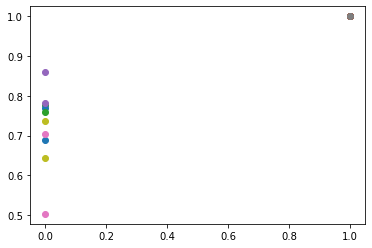

In [269]:
for i in range(len(socio_political_terms)):
    plt.scatter(time_series_df1_socpol_sel[['Time_interval']].iloc[i], 
            time_series_df1_socpol_sel[['Cosine_sim']].iloc[i])
plt.show()

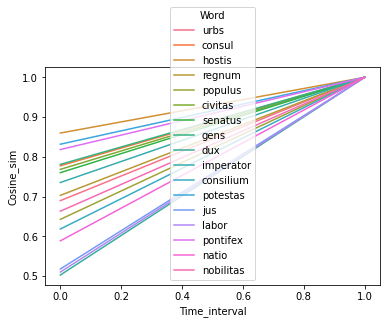

In [270]:
import seaborn as sns
#sns.lmplot('Time_interval', 'Cosine_sim', data=time_series_df_socpol, hue='Word', fit_reg=False)
sns.lineplot(x='Time_interval', y='Cosine_sim', data=time_series_df1_socpol_sel, hue='Word', legend="full")
plt.show()